## Import libraries and training data

In [1]:
import pandas as pd #data frames (for storing data)
import numpy as np #scientific computing
import itertools

#matplotlib for plotting
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.ticker as mtick #for percentage ticks
import scikitplot as skplt 

#sklearn for modeling
from sklearn import tree
from sklearn.preprocessing import LabelEncoder #OneHotEncoding
from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split #Data split function
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

from collections import Counter

import time
import statsmodels.api as sm

from sklearn.preprocessing import scale 
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error

#Decision tree plot
import pydotplus
from IPython.display import Image 

Using TensorFlow backend.


# Training Data

In [2]:
data = pd.read_csv('LC_TrainingData2020.csv')
data.head().style

,loan_amnt,term,installment,emp_title,emp_length,home_ownership,annual_inc,verification_status,loan_status,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,Unnamed: 20
0,14400,60 months,291.92,Senior Director,9,MORTGAGE,135000,Not Verified,Current,Home improvement,070xx,NJ,6.6,1,Oct.99,0,11,nan,15,0,nan
1,4500,36 months,151.06,Lead machine operator,6,RENT,32000,Not Verified,Current,Credit card refinancing,531xx,WI,29.93,0,Apr.11,1,nan,nan,7,0,nan
2,3600,36 months,118.53,IT Specialist 6,11,RENT,89712,Not Verified,Current,Credit card refinancing,984xx,WA,20.3,0,Aug.94,0,nan,nan,16,0,nan
3,7000,36 months,210.81,Nurse,2,RENT,85000,Not Verified,Current,Debt consolidation,112xx,NY,12.8,1,Feb.92,0,20,30,14,1,nan
4,39000,36 months,1370.94,Lead ultrasound technologist,19,MORTGAGE,78000,Source Verified,Current,Debt consolidation,453xx,OH,33.14,0,May.00,0,nan,nan,17,0,nan


## What do we have here

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103514 entries, 0 to 103513
Data columns (total 21 columns):
loan_amnt                 103514 non-null int64
term                      103514 non-null object
installment               103514 non-null float64
emp_title                 96491 non-null object
emp_length                103514 non-null float64
home_ownership            103514 non-null object
annual_inc                103514 non-null float64
verification_status       103514 non-null object
loan_status               103514 non-null object
title                     103514 non-null object
zip_code                  103514 non-null object
addr_state                103514 non-null object
dti                       103514 non-null float64
delinq_2yrs               103514 non-null int64
earliest_cr_line          103514 non-null object
inq_last_6mths            103514 non-null int64
mths_since_last_delinq    55754 non-null float64
mths_since_last_record    21075 non-null float64
open_ac

In [4]:
data.shape

(103514, 21)

In [5]:
data.describe().round()

,loan_amnt,installment,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,Unnamed: 20
count,103514.0,103514.0,103514.0,103514.0,103514.0,103514.0,103514.0,55754.0,21075.0,103514.0,103514.0,0.0
mean,14150.0,434.0,8.0,80759.0,19.0,0.0,1.0,34.0,68.0,12.0,0.0,NaN
std,9215.0,280.0,6.0,77231.0,12.0,1.0,1.0,22.0,25.0,6.0,1.0,NaN
min,1000.0,30.0,0.0,200.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN
25%,7000.0,230.0,2.0,48000.0,12.0,0.0,0.0,15.0,52.0,8.0,0.0,NaN
50%,12000.0,356.0,6.0,67600.0,18.0,0.0,0.0,30.0,71.0,11.0,0.0,NaN
75%,20000.0,582.0,13.0,96000.0,25.0,0.0,1.0,49.0,86.0,15.0,0.0,NaN
max,40000.0,1585.0,20.0,7000055.0,999.0,29.0,5.0,195.0,120.0,97.0,24.0,NaN


## Create target variable

In [6]:
# create target variable no default/default: 0/1

def default_category(row):
    if row['loan_status'] == 'Current' or row['loan_status'] == 'Fully Paid':
        return 0
    else:
        return 1

data = data.assign(default=data.apply(default_category, axis=1))
data.tail().style

,loan_amnt,term,installment,emp_title,emp_length,home_ownership,annual_inc,verification_status,loan_status,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,Unnamed: 20,default
103509,16000,60 months,362.34,Manager,19,RENT,150000,Not Verified,Current,Medical expenses,284xx,NC,12.25,0,Aug.97,0,68,26,12,4,nan,0
103510,24000,60 months,515.74,Current Operations Officer,4,OWN,125000,Not Verified,Current,Credit card refinancing,967xx,HI,10.98,0,Feb.01,0,nan,42,15,2,nan,0
103511,24000,60 months,543.5,Unit Operator,7,MORTGAGE,95000,Source Verified,Current,Home improvement,356xx,AL,19.61,0,Dec.99,0,nan,nan,5,0,nan,0
103512,24000,60 months,515.74,Database Administrator,19,MORTGAGE,108000,Not Verified,Current,Debt consolidation,840xx,UT,34.94,0,Feb.91,1,60,69,24,1,nan,0
103513,24000,60 months,564.56,Program Manager,6,RENT,110000,Not Verified,Late (31-120 days),Debt consolidation,334xx,FL,18.3,0,Jul.99,0,67,72,10,1,nan,1


In [7]:
# dropping the loan status column which we don't need anymore and a redundant empty column that exists for some reason

data = data.drop(['loan_status', 'Unnamed: 20'], axis=1)
data.head().style

,loan_amnt,term,installment,emp_title,emp_length,home_ownership,annual_inc,verification_status,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,default
0,14400,60 months,291.92,Senior Director,9,MORTGAGE,135000,Not Verified,Home improvement,070xx,NJ,6.6,1,Oct.99,0,11,nan,15,0,0
1,4500,36 months,151.06,Lead machine operator,6,RENT,32000,Not Verified,Credit card refinancing,531xx,WI,29.93,0,Apr.11,1,nan,nan,7,0,0
2,3600,36 months,118.53,IT Specialist 6,11,RENT,89712,Not Verified,Credit card refinancing,984xx,WA,20.3,0,Aug.94,0,nan,nan,16,0,0
3,7000,36 months,210.81,Nurse,2,RENT,85000,Not Verified,Debt consolidation,112xx,NY,12.8,1,Feb.92,0,20,30,14,1,0
4,39000,36 months,1370.94,Lead ultrasound technologist,19,MORTGAGE,78000,Source Verified,Debt consolidation,453xx,OH,33.14,0,May.00,0,nan,nan,17,0,0


* loan_amnt: numeric, OK
* term: categoric with two values: 36 and 60 months -> dummy encoding
* installment: numeric, OK
* __emp_title: text + null values -> how to process?__
* emp_length: numeric, OK
* home_ownership: categoric with four values: rent, own, mortgage, any (=other?) -> dummy encoding
* annual_inc: numeric, OK
* verification_status: categoric with two values: not verified/source verified -> dummy encoding
* title: categoric with 12 values -> dummy encoding
* __zip_code: categoric but tooooo many values -> drop??? we also have the state info__
* addr_state: categoric with all the states -> dummy encoding
* dti: numeric, OK
* delinq_2yrs: numeric, OK
* __earliest_cr_line: date information in text format I guess -> convert to date format__
* inq_last_6mths: numeric, OK
* __mths_since_last_delinq: numeric but null values need to be addressed!!__
* __mths_since_last_record: numeric but null values need to be addressed!!__
* open_acc: numeric, OK
* pub_rec: numeric, OK


## Delete months in variable 'term' and turn it into numerical values

In [8]:
new= data["term"].str.split(" ", n = -1, expand = True)
data["term_new"]=new[1]  
data["useless"]= new[2] 
data = data.drop(['useless'], axis=1)
data['term_new']=data['term_new'].astype(int)
data=data.drop(['term'], axis=1)
data.head().style

,loan_amnt,installment,emp_title,emp_length,home_ownership,annual_inc,verification_status,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,default,term_new
0,14400,291.92,Senior Director,9,MORTGAGE,135000,Not Verified,Home improvement,070xx,NJ,6.6,1,Oct.99,0,11,nan,15,0,0,60
1,4500,151.06,Lead machine operator,6,RENT,32000,Not Verified,Credit card refinancing,531xx,WI,29.93,0,Apr.11,1,nan,nan,7,0,0,36
2,3600,118.53,IT Specialist 6,11,RENT,89712,Not Verified,Credit card refinancing,984xx,WA,20.3,0,Aug.94,0,nan,nan,16,0,0,36
3,7000,210.81,Nurse,2,RENT,85000,Not Verified,Debt consolidation,112xx,NY,12.8,1,Feb.92,0,20,30,14,1,0,36
4,39000,1370.94,Lead ultrasound technologist,19,MORTGAGE,78000,Source Verified,Debt consolidation,453xx,OH,33.14,0,May.00,0,nan,nan,17,0,0,36


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103514 entries, 0 to 103513
Data columns (total 20 columns):
loan_amnt                 103514 non-null int64
installment               103514 non-null float64
emp_title                 96491 non-null object
emp_length                103514 non-null float64
home_ownership            103514 non-null object
annual_inc                103514 non-null float64
verification_status       103514 non-null object
title                     103514 non-null object
zip_code                  103514 non-null object
addr_state                103514 non-null object
dti                       103514 non-null float64
delinq_2yrs               103514 non-null int64
earliest_cr_line          103514 non-null object
inq_last_6mths            103514 non-null int64
mths_since_last_delinq    55754 non-null float64
mths_since_last_record    21075 non-null float64
open_acc                  103514 non-null int64
pub_rec                   103514 non-null int64
default  

## Convert earliest_cr_line to age of earliest cr line (in months):

In [10]:
data[['earliest_cr_Month','earliest_cr_Year']] = data.earliest_cr_line.str.split(".",expand=True,)
data.head().style

,loan_amnt,installment,emp_title,emp_length,home_ownership,annual_inc,verification_status,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,default,term_new,earliest_cr_Month,earliest_cr_Year
0,14400,291.92,Senior Director,9,MORTGAGE,135000,Not Verified,Home improvement,070xx,NJ,6.6,1,Oct.99,0,11,nan,15,0,0,60,Oct,99
1,4500,151.06,Lead machine operator,6,RENT,32000,Not Verified,Credit card refinancing,531xx,WI,29.93,0,Apr.11,1,nan,nan,7,0,0,36,Apr,11
2,3600,118.53,IT Specialist 6,11,RENT,89712,Not Verified,Credit card refinancing,984xx,WA,20.3,0,Aug.94,0,nan,nan,16,0,0,36,Aug,94
3,7000,210.81,Nurse,2,RENT,85000,Not Verified,Debt consolidation,112xx,NY,12.8,1,Feb.92,0,20,30,14,1,0,36,Feb,92
4,39000,1370.94,Lead ultrasound technologist,19,MORTGAGE,78000,Source Verified,Debt consolidation,453xx,OH,33.14,0,May.00,0,nan,nan,17,0,0,36,May,00


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103514 entries, 0 to 103513
Data columns (total 22 columns):
loan_amnt                 103514 non-null int64
installment               103514 non-null float64
emp_title                 96491 non-null object
emp_length                103514 non-null float64
home_ownership            103514 non-null object
annual_inc                103514 non-null float64
verification_status       103514 non-null object
title                     103514 non-null object
zip_code                  103514 non-null object
addr_state                103514 non-null object
dti                       103514 non-null float64
delinq_2yrs               103514 non-null int64
earliest_cr_line          103514 non-null object
inq_last_6mths            103514 non-null int64
mths_since_last_delinq    55754 non-null float64
mths_since_last_record    21075 non-null float64
open_acc                  103514 non-null int64
pub_rec                   103514 non-null int64
default  

In [12]:
def new_column_earliest_cr_Day(row):
    return 1

data = data.assign(earliest_cr_Day=data.apply(new_column_earliest_cr_Day, axis=1))
data.head(50).style

,loan_amnt,installment,emp_title,emp_length,home_ownership,annual_inc,verification_status,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,default,term_new,earliest_cr_Month,earliest_cr_Year,earliest_cr_Day
0,14400,291.92,Senior Director,9,MORTGAGE,135000,Not Verified,Home improvement,070xx,NJ,6.6,1,Oct.99,0,11,nan,15,0,0,60,Oct,99,1
1,4500,151.06,Lead machine operator,6,RENT,32000,Not Verified,Credit card refinancing,531xx,WI,29.93,0,Apr.11,1,nan,nan,7,0,0,36,Apr,11,1
2,3600,118.53,IT Specialist 6,11,RENT,89712,Not Verified,Credit card refinancing,984xx,WA,20.3,0,Aug.94,0,nan,nan,16,0,0,36,Aug,94,1
3,7000,210.81,Nurse,2,RENT,85000,Not Verified,Debt consolidation,112xx,NY,12.8,1,Feb.92,0,20,30,14,1,0,36,Feb,92,1
4,39000,1370.94,Lead ultrasound technologist,19,MORTGAGE,78000,Source Verified,Debt consolidation,453xx,OH,33.14,0,May.00,0,nan,nan,17,0,0,36,May,00,1
5,20000,712.96,teacher,11,MORTGAGE,63000,Not Verified,Debt consolidation,011xx,MA,29.03,1,marras.90,2,23,71,15,1,0,36,marras,90,1
6,8000,250.66,Techniti,20,MORTGAGE,57000,Source Verified,Credit card refinancing,666xx,KS,28.45,3,Oct.96,0,7,nan,7,0,0,36,Oct,96,1
7,9300,292.46,Banquet server,9,MORTGAGE,62000,Source Verified,Debt consolidation,481xx,MI,16.12,0,Jun.03,1,71,99,14,1,0,36,Jun,03,1
8,18000,563.98,Equipment Management,2,MORTGAGE,60000,Not Verified,Debt consolidation,329xx,FL,30.76,0,Oct.00,0,nan,nan,13,0,0,36,Oct,00,1
9,5000,162.49,driver,11,RENT,75000,Not Verified,Other,891xx,NV,11.01,0,Oct.90,1,nan,74,4,1,0,36,Oct,90,1


In [13]:
data.head(50).style

,loan_amnt,installment,emp_title,emp_length,home_ownership,annual_inc,verification_status,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,default,term_new,earliest_cr_Month,earliest_cr_Year,earliest_cr_Day
0,14400,291.92,Senior Director,9,MORTGAGE,135000,Not Verified,Home improvement,070xx,NJ,6.6,1,Oct.99,0,11,nan,15,0,0,60,Oct,99,1
1,4500,151.06,Lead machine operator,6,RENT,32000,Not Verified,Credit card refinancing,531xx,WI,29.93,0,Apr.11,1,nan,nan,7,0,0,36,Apr,11,1
2,3600,118.53,IT Specialist 6,11,RENT,89712,Not Verified,Credit card refinancing,984xx,WA,20.3,0,Aug.94,0,nan,nan,16,0,0,36,Aug,94,1
3,7000,210.81,Nurse,2,RENT,85000,Not Verified,Debt consolidation,112xx,NY,12.8,1,Feb.92,0,20,30,14,1,0,36,Feb,92,1
4,39000,1370.94,Lead ultrasound technologist,19,MORTGAGE,78000,Source Verified,Debt consolidation,453xx,OH,33.14,0,May.00,0,nan,nan,17,0,0,36,May,00,1
5,20000,712.96,teacher,11,MORTGAGE,63000,Not Verified,Debt consolidation,011xx,MA,29.03,1,marras.90,2,23,71,15,1,0,36,marras,90,1
6,8000,250.66,Techniti,20,MORTGAGE,57000,Source Verified,Credit card refinancing,666xx,KS,28.45,3,Oct.96,0,7,nan,7,0,0,36,Oct,96,1
7,9300,292.46,Banquet server,9,MORTGAGE,62000,Source Verified,Debt consolidation,481xx,MI,16.12,0,Jun.03,1,71,99,14,1,0,36,Jun,03,1
8,18000,563.98,Equipment Management,2,MORTGAGE,60000,Not Verified,Debt consolidation,329xx,FL,30.76,0,Oct.00,0,nan,nan,13,0,0,36,Oct,00,1
9,5000,162.49,driver,11,RENT,75000,Not Verified,Other,891xx,NV,11.01,0,Oct.90,1,nan,74,4,1,0,36,Oct,90,1


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103514 entries, 0 to 103513
Data columns (total 23 columns):
loan_amnt                 103514 non-null int64
installment               103514 non-null float64
emp_title                 96491 non-null object
emp_length                103514 non-null float64
home_ownership            103514 non-null object
annual_inc                103514 non-null float64
verification_status       103514 non-null object
title                     103514 non-null object
zip_code                  103514 non-null object
addr_state                103514 non-null object
dti                       103514 non-null float64
delinq_2yrs               103514 non-null int64
earliest_cr_line          103514 non-null object
inq_last_6mths            103514 non-null int64
mths_since_last_delinq    55754 non-null float64
mths_since_last_record    21075 non-null float64
open_acc                  103514 non-null int64
pub_rec                   103514 non-null int64
default  

In [15]:
## fix for formatting error that appears in finnish language version when csv has been opened in excel etc....

def marras_to_Mar(row):
    if row['earliest_cr_Month'] == 'marras':
        return 'Mar'
    else:
        return row['earliest_cr_Month']

data = data.assign(earliest_cr_Month=data.apply(marras_to_Mar, axis=1))
data.head(50).style

,loan_amnt,installment,emp_title,emp_length,home_ownership,annual_inc,verification_status,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,default,term_new,earliest_cr_Month,earliest_cr_Year,earliest_cr_Day
0,14400,291.92,Senior Director,9,MORTGAGE,135000,Not Verified,Home improvement,070xx,NJ,6.6,1,Oct.99,0,11,nan,15,0,0,60,Oct,99,1
1,4500,151.06,Lead machine operator,6,RENT,32000,Not Verified,Credit card refinancing,531xx,WI,29.93,0,Apr.11,1,nan,nan,7,0,0,36,Apr,11,1
2,3600,118.53,IT Specialist 6,11,RENT,89712,Not Verified,Credit card refinancing,984xx,WA,20.3,0,Aug.94,0,nan,nan,16,0,0,36,Aug,94,1
3,7000,210.81,Nurse,2,RENT,85000,Not Verified,Debt consolidation,112xx,NY,12.8,1,Feb.92,0,20,30,14,1,0,36,Feb,92,1
4,39000,1370.94,Lead ultrasound technologist,19,MORTGAGE,78000,Source Verified,Debt consolidation,453xx,OH,33.14,0,May.00,0,nan,nan,17,0,0,36,May,00,1
5,20000,712.96,teacher,11,MORTGAGE,63000,Not Verified,Debt consolidation,011xx,MA,29.03,1,marras.90,2,23,71,15,1,0,36,Mar,90,1
6,8000,250.66,Techniti,20,MORTGAGE,57000,Source Verified,Credit card refinancing,666xx,KS,28.45,3,Oct.96,0,7,nan,7,0,0,36,Oct,96,1
7,9300,292.46,Banquet server,9,MORTGAGE,62000,Source Verified,Debt consolidation,481xx,MI,16.12,0,Jun.03,1,71,99,14,1,0,36,Jun,03,1
8,18000,563.98,Equipment Management,2,MORTGAGE,60000,Not Verified,Debt consolidation,329xx,FL,30.76,0,Oct.00,0,nan,nan,13,0,0,36,Oct,00,1
9,5000,162.49,driver,11,RENT,75000,Not Verified,Other,891xx,NV,11.01,0,Oct.90,1,nan,74,4,1,0,36,Oct,90,1


In [16]:
import datetime

def to_dates(row):
    x = row['earliest_cr_Month'] + str(row['earliest_cr_Day']) + str(row['earliest_cr_Year'])
    mydate = datetime.datetime.strptime(x, '%b%d%y')
    return mydate

data = data.assign(date_earliest_cr_line=data.apply(to_dates, axis=1))

In [17]:
data.head().style

,loan_amnt,installment,emp_title,emp_length,home_ownership,annual_inc,verification_status,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,default,term_new,earliest_cr_Month,earliest_cr_Year,earliest_cr_Day,date_earliest_cr_line
0,14400,291.92,Senior Director,9,MORTGAGE,135000,Not Verified,Home improvement,070xx,NJ,6.6,1,Oct.99,0,11,nan,15,0,0,60,Oct,99,1,1999-10-01 00:00:00
1,4500,151.06,Lead machine operator,6,RENT,32000,Not Verified,Credit card refinancing,531xx,WI,29.93,0,Apr.11,1,nan,nan,7,0,0,36,Apr,11,1,2011-04-01 00:00:00
2,3600,118.53,IT Specialist 6,11,RENT,89712,Not Verified,Credit card refinancing,984xx,WA,20.3,0,Aug.94,0,nan,nan,16,0,0,36,Aug,94,1,1994-08-01 00:00:00
3,7000,210.81,Nurse,2,RENT,85000,Not Verified,Debt consolidation,112xx,NY,12.8,1,Feb.92,0,20,30,14,1,0,36,Feb,92,1,1992-02-01 00:00:00
4,39000,1370.94,Lead ultrasound technologist,19,MORTGAGE,78000,Source Verified,Debt consolidation,453xx,OH,33.14,0,May.00,0,nan,nan,17,0,0,36,May,00,1,2000-05-01 00:00:00


In [18]:
def calculate_age_in_months(row):
    end_date = datetime.datetime.strptime(str('2014-02-01'), '%Y-%m-%d')
    return (end_date.year - row['date_earliest_cr_line'].year) * 12 + end_date.month - row['date_earliest_cr_line'].month

data = data.assign(age_of_earliest_cr_line=data.apply(calculate_age_in_months, axis=1))

In [19]:
data.head().style

,loan_amnt,installment,emp_title,emp_length,home_ownership,annual_inc,verification_status,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,default,term_new,earliest_cr_Month,earliest_cr_Year,earliest_cr_Day,date_earliest_cr_line,age_of_earliest_cr_line
0,14400,291.92,Senior Director,9,MORTGAGE,135000,Not Verified,Home improvement,070xx,NJ,6.6,1,Oct.99,0,11,nan,15,0,0,60,Oct,99,1,1999-10-01 00:00:00,172
1,4500,151.06,Lead machine operator,6,RENT,32000,Not Verified,Credit card refinancing,531xx,WI,29.93,0,Apr.11,1,nan,nan,7,0,0,36,Apr,11,1,2011-04-01 00:00:00,34
2,3600,118.53,IT Specialist 6,11,RENT,89712,Not Verified,Credit card refinancing,984xx,WA,20.3,0,Aug.94,0,nan,nan,16,0,0,36,Aug,94,1,1994-08-01 00:00:00,234
3,7000,210.81,Nurse,2,RENT,85000,Not Verified,Debt consolidation,112xx,NY,12.8,1,Feb.92,0,20,30,14,1,0,36,Feb,92,1,1992-02-01 00:00:00,264
4,39000,1370.94,Lead ultrasound technologist,19,MORTGAGE,78000,Source Verified,Debt consolidation,453xx,OH,33.14,0,May.00,0,nan,nan,17,0,0,36,May,00,1,2000-05-01 00:00:00,165


In [20]:
data = data.drop(['earliest_cr_line', 'earliest_cr_Month', 'earliest_cr_Year', 'earliest_cr_Day', 'date_earliest_cr_line'], axis=1)
data.head().style

,loan_amnt,installment,emp_title,emp_length,home_ownership,annual_inc,verification_status,title,zip_code,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,default,term_new,age_of_earliest_cr_line
0,14400,291.92,Senior Director,9,MORTGAGE,135000,Not Verified,Home improvement,070xx,NJ,6.6,1,0,11,nan,15,0,0,60,172
1,4500,151.06,Lead machine operator,6,RENT,32000,Not Verified,Credit card refinancing,531xx,WI,29.93,0,1,nan,nan,7,0,0,36,34
2,3600,118.53,IT Specialist 6,11,RENT,89712,Not Verified,Credit card refinancing,984xx,WA,20.3,0,0,nan,nan,16,0,0,36,234
3,7000,210.81,Nurse,2,RENT,85000,Not Verified,Debt consolidation,112xx,NY,12.8,1,0,20,30,14,1,0,36,264
4,39000,1370.94,Lead ultrasound technologist,19,MORTGAGE,78000,Source Verified,Debt consolidation,453xx,OH,33.14,0,0,nan,nan,17,0,0,36,165


## Problem with variable zip_code -> just deleting it for now

In [21]:
data = data.drop(['zip_code'], axis=1)

## Categorize variable emp_title

In [22]:
data['emp_title'] = data['emp_title'].fillna('NO_VALUE')
def emp_title_category(row):
    if row['emp_title'] == "NO_VALUE" and row['emp_length'] > 0:
        return "Employed"
    elif row['emp_title'] == "NO_VALUE" and row['emp_length'] == 0:
        return "Unemployed"
    else:
        return "Employed"

data = data.assign(emp_title_new=data.apply(emp_title_category, axis=1))
data.head(35).style

,loan_amnt,installment,emp_title,emp_length,home_ownership,annual_inc,verification_status,title,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,default,term_new,age_of_earliest_cr_line,emp_title_new
0,14400,291.92,Senior Director,9,MORTGAGE,135000,Not Verified,Home improvement,NJ,6.6,1,0,11,nan,15,0,0,60,172,Employed
1,4500,151.06,Lead machine operator,6,RENT,32000,Not Verified,Credit card refinancing,WI,29.93,0,1,nan,nan,7,0,0,36,34,Employed
2,3600,118.53,IT Specialist 6,11,RENT,89712,Not Verified,Credit card refinancing,WA,20.3,0,0,nan,nan,16,0,0,36,234,Employed
3,7000,210.81,Nurse,2,RENT,85000,Not Verified,Debt consolidation,NY,12.8,1,0,20,30,14,1,0,36,264,Employed
4,39000,1370.94,Lead ultrasound technologist,19,MORTGAGE,78000,Source Verified,Debt consolidation,OH,33.14,0,0,nan,nan,17,0,0,36,165,Employed
5,20000,712.96,teacher,11,MORTGAGE,63000,Not Verified,Debt consolidation,MA,29.03,1,2,23,71,15,1,0,36,287,Employed
6,8000,250.66,Techniti,20,MORTGAGE,57000,Source Verified,Credit card refinancing,KS,28.45,3,0,7,nan,7,0,0,36,208,Employed
7,9300,292.46,Banquet server,9,MORTGAGE,62000,Source Verified,Debt consolidation,MI,16.12,0,1,71,99,14,1,0,36,128,Employed
8,18000,563.98,Equipment Management,2,MORTGAGE,60000,Not Verified,Debt consolidation,FL,30.76,0,0,nan,nan,13,0,0,36,160,Employed
9,5000,162.49,driver,11,RENT,75000,Not Verified,Other,NV,11.01,0,1,nan,74,4,1,0,36,280,Employed


In [23]:
data=pd.get_dummies(data, columns=['emp_title_new'])
data=data.drop(['emp_title'], axis=1)
data.head(35).style

,loan_amnt,installment,emp_length,home_ownership,annual_inc,verification_status,title,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,default,term_new,age_of_earliest_cr_line,emp_title_new_Employed,emp_title_new_Unemployed
0,14400,291.92,9,MORTGAGE,135000,Not Verified,Home improvement,NJ,6.6,1,0,11,nan,15,0,0,60,172,1,0
1,4500,151.06,6,RENT,32000,Not Verified,Credit card refinancing,WI,29.93,0,1,nan,nan,7,0,0,36,34,1,0
2,3600,118.53,11,RENT,89712,Not Verified,Credit card refinancing,WA,20.3,0,0,nan,nan,16,0,0,36,234,1,0
3,7000,210.81,2,RENT,85000,Not Verified,Debt consolidation,NY,12.8,1,0,20,30,14,1,0,36,264,1,0
4,39000,1370.94,19,MORTGAGE,78000,Source Verified,Debt consolidation,OH,33.14,0,0,nan,nan,17,0,0,36,165,1,0
5,20000,712.96,11,MORTGAGE,63000,Not Verified,Debt consolidation,MA,29.03,1,2,23,71,15,1,0,36,287,1,0
6,8000,250.66,20,MORTGAGE,57000,Source Verified,Credit card refinancing,KS,28.45,3,0,7,nan,7,0,0,36,208,1,0
7,9300,292.46,9,MORTGAGE,62000,Source Verified,Debt consolidation,MI,16.12,0,1,71,99,14,1,0,36,128,1,0
8,18000,563.98,2,MORTGAGE,60000,Not Verified,Debt consolidation,FL,30.76,0,0,nan,nan,13,0,0,36,160,1,0
9,5000,162.49,11,RENT,75000,Not Verified,Other,NV,11.01,0,1,nan,74,4,1,0,36,280,1,0


## Categorize variables mths_since_last_delinq and mths_since_last_record

In [24]:
data['mths_since_last_delinq'] = data['mths_since_last_delinq'].fillna('10000')
data['mths_since_last_record'] = data['mths_since_last_record'].fillna('10000')
data['mths_since_last_delinq']=data['mths_since_last_delinq'].astype(int)
data['mths_since_last_record']=data['mths_since_last_record'].astype(int)
data.tail(10).style

,loan_amnt,installment,emp_length,home_ownership,annual_inc,verification_status,title,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,default,term_new,age_of_earliest_cr_line,emp_title_new_Employed,emp_title_new_Unemployed
103504,23800,559.85,20,MORTGAGE,119000,Not Verified,Debt consolidation,OH,32.73,0,1,10000,10000,13,0,0,60,258,1,0
103505,18000,377.95,5,OWN,130000,Not Verified,Home improvement,TX,20.59,0,1,10000,10000,17,0,0,60,115,1,0
103506,40000,859.56,5,MORTGAGE,150000,Verified,Debt consolidation,FL,15.47,0,0,10000,10000,7,0,0,60,189,1,0
103507,29400,683.94,9,MORTGAGE,180792,Not Verified,Debt consolidation,CA,22.03,0,1,10000,10000,16,0,0,60,143,1,0
103508,32000,752.74,3,MORTGAGE,157000,Source Verified,Home improvement,AZ,10.34,0,0,10000,10000,14,0,1,60,32,1,0
103509,16000,362.34,19,RENT,150000,Not Verified,Medical expenses,NC,12.25,0,0,68,26,12,4,0,60,198,1,0
103510,24000,515.74,4,OWN,125000,Not Verified,Credit card refinancing,HI,10.98,0,0,10000,42,15,2,0,60,156,1,0
103511,24000,543.5,7,MORTGAGE,95000,Source Verified,Home improvement,AL,19.61,0,0,10000,10000,5,0,0,60,170,1,0
103512,24000,515.74,19,MORTGAGE,108000,Not Verified,Debt consolidation,UT,34.94,0,1,60,69,24,1,0,60,276,1,0
103513,24000,564.56,6,RENT,110000,Not Verified,Debt consolidation,FL,18.3,0,0,67,72,10,1,1,60,175,1,0


In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103514 entries, 0 to 103513
Data columns (total 20 columns):
loan_amnt                   103514 non-null int64
installment                 103514 non-null float64
emp_length                  103514 non-null float64
home_ownership              103514 non-null object
annual_inc                  103514 non-null float64
verification_status         103514 non-null object
title                       103514 non-null object
addr_state                  103514 non-null object
dti                         103514 non-null float64
delinq_2yrs                 103514 non-null int64
inq_last_6mths              103514 non-null int64
mths_since_last_delinq      103514 non-null int64
mths_since_last_record      103514 non-null int64
open_acc                    103514 non-null int64
pub_rec                     103514 non-null int64
default                     103514 non-null int64
term_new                    103514 non-null int64
age_of_earliest_cr_line    

## Dummy encoding for home_ownership, verification_status, title, addr_state

In [26]:
data = pd.get_dummies(data, columns=['home_ownership', 'verification_status', 'title'])
data.head().style

,loan_amnt,installment,emp_length,annual_inc,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,default,term_new,age_of_earliest_cr_line,emp_title_new_Employed,emp_title_new_Unemployed,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,title_Business,title_Car financing,title_Credit card refinancing,title_Debt consolidation,title_Green loan,title_Home buying,title_Home improvement,title_Major purchase,title_Medical expenses,title_Moving and relocation,title_Other,title_Vacation
0,14400,291.92,9,135000,NJ,6.6,1,0,11,10000,15,0,0,60,172,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,4500,151.06,6,32000,WI,29.93,0,1,10000,10000,7,0,0,36,34,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,3600,118.53,11,89712,WA,20.3,0,0,10000,10000,16,0,0,36,234,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,7000,210.81,2,85000,NY,12.8,1,0,20,30,14,1,0,36,264,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,39000,1370.94,19,78000,OH,33.14,0,0,10000,10000,17,0,0,36,165,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0


In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103514 entries, 0 to 103513
Data columns (total 36 columns):
loan_amnt                              103514 non-null int64
installment                            103514 non-null float64
emp_length                             103514 non-null float64
annual_inc                             103514 non-null float64
addr_state                             103514 non-null object
dti                                    103514 non-null float64
delinq_2yrs                            103514 non-null int64
inq_last_6mths                         103514 non-null int64
mths_since_last_delinq                 103514 non-null int64
mths_since_last_record                 103514 non-null int64
open_acc                               103514 non-null int64
pub_rec                                103514 non-null int64
default                                103514 non-null int64
term_new                               103514 non-null int64
age_of_earliest_cr_line   

In [28]:
#grouping the states into 4 groups: northeast= ME, NH, VT, MA, RI, CT, NJ, NY, PA
#MIDWEST= ND, SD, NE, KS, MN, IA, MO, WI, IL, MI, IN, OH
#SOUTH = OK, TX, AR, LA, KY, TN, MS, AL, FL, GA, SC, NC, VA,WV, MD, DC, DE
#WEST=WA, ID, MT, OR, WY, CA, NV, UT, CO, AZ, NM, AK, HI


In [29]:
data.addr_state.unique()


array(['NJ', 'WI', 'WA', 'NY', 'OH', 'MA', 'KS', 'MI', 'FL', 'NV', 'IN',
       'CT', 'CA', 'GA', 'OK', 'LA', 'AZ', 'CO', 'MO', 'IL', 'MD', 'TN',
       'TX', 'NE', 'UT', 'OR', 'ND', 'NC', 'MS', 'AR', 'AL', 'MN', 'PA',
       'VA', 'RI', 'DE', 'WY', 'NH', 'KY', 'HI', 'SC', 'MT', 'ID', 'ME',
       'VT', 'AK', 'NM', 'DC', 'SD'], dtype=object)

In [30]:
#NORTHEAST
def northeast(row):
    if row['addr_state'] == 'ME' :
        return 'north_east'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(northeast, axis=1))

def northeast(row):
    if row['addr_state'] == 'NH' :
        return 'north_east'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(northeast, axis=1))


def northeast(row):
    if row['addr_state'] == 'VT' :
        return 'north_east'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(northeast, axis=1))

def northeast(row):
    if row['addr_state'] == 'MA' :
        return 'north_east'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(northeast, axis=1))

def northeast(row):
    if row['addr_state'] == 'RI' :
        return 'north_east'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(northeast, axis=1))

def northeast(row):
    if row['addr_state'] == 'CT' :
        return 'north_east'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(northeast, axis=1))

def northeast(row):
    if row['addr_state'] == 'NJ' :
        return 'north_east'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(northeast, axis=1))

def northeast(row):
    if row['addr_state'] == 'NY' :
        return 'north_east'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(northeast, axis=1))

def northeast(row):
    if row['addr_state'] == 'PA' :
        return 'north_east'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(northeast, axis=1))


In [31]:
#MIDWEST

def midwest(row):
    if row['addr_state'] == 'ND' :
        return 'mid_west'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(midwest, axis=1))

def midwest(row):
    if row['addr_state'] == 'SD' :
        return 'mid_west'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(midwest, axis=1))

def midwest(row):
    if row['addr_state'] == 'NE' :
        return 'mid_west'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(midwest, axis=1))

def midwest(row):
    if row['addr_state'] == 'KS' :
        return 'mid_west'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(midwest, axis=1))

def midwest(row):
    if row['addr_state'] == 'MN' :
        return 'mid_west'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(midwest, axis=1))

def midwest(row):
    if row['addr_state'] == 'IA' :
        return 'mid_west'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(midwest, axis=1))

def midwest(row):
    if row['addr_state'] == 'MO' :
        return 'mid_west'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(midwest, axis=1))

def midwest(row):
    if row['addr_state'] == 'WI' :
        return 'mid_west'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(midwest, axis=1))

def midwest(row):
    if row['addr_state'] == 'IL' :
        return 'mid_west'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(midwest, axis=1))

def midwest(row):
    if row['addr_state'] == 'MI' :
        return 'mid_west'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(midwest, axis=1))

def midwest(row):
    if row['addr_state'] == 'IN' :
        return 'mid_west'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(midwest, axis=1))

def midwest(row):
    if row['addr_state'] == 'OH' :
        return 'mid_west'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(midwest, axis=1))

In [32]:
#SOUTH
def South(row):
    if row['addr_state'] == 'OK' :
        return 'south'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(South, axis=1))

def South(row):
    if row['addr_state'] == 'TX' :
        return 'south'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(South, axis=1))

def South(row):
    if row['addr_state'] == 'AR' :
        return 'south'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(South, axis=1))

def South(row):
    if row['addr_state'] == 'LA' :
        return 'south'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(South, axis=1))

def South(row):
    if row['addr_state'] == 'KY' :
        return 'south'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(South, axis=1))

def South(row):
    if row['addr_state'] == 'TN' :
        return 'south'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(South, axis=1))

def South(row):
    if row['addr_state'] == 'MS' :
        return 'south'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(South, axis=1))

def South(row):
    if row['addr_state'] == 'AL' :
        return 'south'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(South, axis=1))

def South(row):
    if row['addr_state'] == 'FL' :
        return 'south'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(South, axis=1))

def South(row):
    if row['addr_state'] == 'GA' :
        return 'south'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(South, axis=1))

def South(row):
    if row['addr_state'] == 'SC' :
        return 'south'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(South, axis=1))

def South(row):
    if row['addr_state'] == 'NC' :
        return 'south'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(South, axis=1))

def South(row):
    if row['addr_state'] == 'VA' :
        return 'south'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(South, axis=1))

def South(row):
    if row['addr_state'] == 'WV' :
        return 'south'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(South, axis=1))

def South(row):
    if row['addr_state'] == 'MD' :
        return 'south'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(South, axis=1))

def South(row):
    if row['addr_state'] == 'DC' :
        return 'south'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(South, axis=1))

def South(row):
    if row['addr_state'] == 'DE' :
        return 'south'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(South, axis=1))

In [33]:
def West(row):
    if row['addr_state'] == 'WA' :
        return 'west'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(West, axis=1))

def West(row):
    if row['addr_state'] == 'ID' :
        return 'west'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(West, axis=1))

def West(row):
    if row['addr_state'] == 'MT' :
        return 'west'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(West, axis=1))

def West(row):
    if row['addr_state'] == 'OR' :
        return 'west'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(West, axis=1))

def West(row):
    if row['addr_state'] == 'WY' :
        return 'west'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(West, axis=1))

def West(row):
    if row['addr_state'] == 'CA' :
        return 'west'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(West, axis=1))

def West(row):
    if row['addr_state'] == 'NV' :
        return 'west'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(West, axis=1))

def West(row):
    if row['addr_state'] == 'UT' :
        return 'west'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(West, axis=1))

def West(row):
    if row['addr_state'] == 'CO' :
        return 'west'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(West, axis=1))

def West(row):
    if row['addr_state'] == 'AZ' :
        return 'west'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(West, axis=1))

def West(row):
    if row['addr_state'] == 'NM' :
        return 'west'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(West, axis=1))

def West(row):
    if row['addr_state'] == 'AK' :
        return 'west'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(West, axis=1))

def West(row):
    if row['addr_state'] == 'HI' :
        return 'west'
    else:
        return row['addr_state']

data = data.assign(addr_state=data.apply(West, axis=1))

In [34]:
data.addr_state.unique()

array(['north_east', 'mid_west', 'west', 'south'], dtype=object)

In [35]:
data.head()

,loan_amnt,installment,emp_length,annual_inc,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,...,title_Credit card refinancing,title_Debt consolidation,title_Green loan,title_Home buying,title_Home improvement,title_Major purchase,title_Medical expenses,title_Moving and relocation,title_Other,title_Vacation
0,14400,291.92,9.0,135000.0,north_east,6.60,1,0,11,10000,...,0,0,0,0,1,0,0,0,0,0
1,4500,151.06,6.0,32000.0,mid_west,29.93,0,1,10000,10000,...,1,0,0,0,0,0,0,0,0,0
2,3600,118.53,11.0,89712.0,west,20.30,0,0,10000,10000,...,1,0,0,0,0,0,0,0,0,0
3,7000,210.81,2.0,85000.0,north_east,12.80,1,0,20,30,...,0,1,0,0,0,0,0,0,0,0
4,39000,1370.94,19.0,78000.0,mid_west,33.14,0,0,10000,10000,...,0,1,0,0,0,0,0,0,0,0


In [36]:
data=pd.get_dummies(data, columns=['addr_state'])

In [37]:
data.head()

,loan_amnt,installment,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,...,title_Home improvement,title_Major purchase,title_Medical expenses,title_Moving and relocation,title_Other,title_Vacation,addr_state_mid_west,addr_state_north_east,addr_state_south,addr_state_west
0,14400,291.92,9.0,135000.0,6.60,1,0,11,10000,15,...,1,0,0,0,0,0,0,1,0,0
1,4500,151.06,6.0,32000.0,29.93,0,1,10000,10000,7,...,0,0,0,0,0,0,1,0,0,0
2,3600,118.53,11.0,89712.0,20.30,0,0,10000,10000,16,...,0,0,0,0,0,0,0,0,0,1
3,7000,210.81,2.0,85000.0,12.80,1,0,20,30,14,...,0,0,0,0,0,0,0,1,0,0
4,39000,1370.94,19.0,78000.0,33.14,0,0,10000,10000,17,...,0,0,0,0,0,0,1,0,0,0


In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103514 entries, 0 to 103513
Data columns (total 39 columns):
loan_amnt                              103514 non-null int64
installment                            103514 non-null float64
emp_length                             103514 non-null float64
annual_inc                             103514 non-null float64
dti                                    103514 non-null float64
delinq_2yrs                            103514 non-null int64
inq_last_6mths                         103514 non-null int64
mths_since_last_delinq                 103514 non-null int64
mths_since_last_record                 103514 non-null int64
open_acc                               103514 non-null int64
pub_rec                                103514 non-null int64
default                                103514 non-null int64
term_new                               103514 non-null int64
age_of_earliest_cr_line                103514 non-null int64
emp_title_new_Employed     

# Testing Data

In [39]:
data_test_withint = pd.read_csv('LC_TestData_2020.csv')
data_test_withint['int_rate'] = list(map(lambda x: x[:-1], data_test_withint['int_rate'].values))
data_test_withint['int_rate'] = [float(x) for x in data_test_withint['int_rate'].values]
data_test_withint['int_rate'] = data_test_withint['int_rate'] / 100
data_test = pd.read_csv('LC_TestData_2020.csv')
data_test.head().style

,loan_amnt,term,int_rate,installment,emp_title,emp_length,home_ownership,annual_inc,verification_status,loan_status,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,Unnamed: 21
0,15000,36 months,5.32 %,451.73,Executive Account Manager,16,MORTGAGE,182000,Not Verified,Current,Debt consolidation,751xx,TX,9.35,0,Nov.74,0,nan,nan,13,0,nan
1,17000,36 months,7.49 %,528.73,Air Traffic Controller,20,MORTGAGE,120000,Not Verified,Fully Paid,Debt consolidation,840xx,UT,8.41,0,Oct.05,0,72,89,9,1,nan
2,20000,36 months,5.32 %,602.3,Associate Dentist,3,RENT,120000,Not Verified,Current,Credit card refinancing,926xx,CA,26.54,0,Aug.02,1,nan,nan,18,0,nan
3,16000,60 months,12.74 %,361.93,claims analyst,19,MORTGAGE,130000,Not Verified,Current,Debt consolidation,577xx,SD,8.28,0,Jul.95,0,42,79,16,1,nan
4,2000,36 months,16.99 %,71.3,Supervisor,6,MORTGAGE,62000,Not Verified,Current,Credit card refinancing,983xx,WA,16.43,0,Oct.07,2,57,44,10,2,nan


In [40]:
data_test_withint.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96745 entries, 0 to 96744
Data columns (total 22 columns):
loan_amnt                 96745 non-null int64
term                      96745 non-null object
int_rate                  96745 non-null float64
installment               96745 non-null float64
emp_title                 89884 non-null object
emp_length                96745 non-null float64
home_ownership            96745 non-null object
annual_inc                96745 non-null float64
verification_status       96745 non-null object
loan_status               96745 non-null object
title                     96745 non-null object
zip_code                  96745 non-null object
addr_state                96745 non-null object
dti                       96745 non-null float64
delinq_2yrs               96745 non-null int64
earliest_cr_line          96745 non-null object
inq_last_6mths            96745 non-null int64
mths_since_last_delinq    50474 non-null float64
mths_since_last_record  

In [41]:
data_test.describe().round()

,loan_amnt,installment,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,Unnamed: 21
count,96745.0,96745.0,96745.0,96745.0,96745.0,96745.0,96745.0,50474.0,19099.0,96745.0,96745.0,0.0
mean,14856.0,451.0,8.0,82790.0,19.0,0.0,1.0,34.0,69.0,12.0,0.0,NaN
std,9395.0,283.0,6.0,214976.0,13.0,1.0,1.0,22.0,26.0,6.0,1.0,NaN
min,1000.0,30.0,0.0,400.0,-1.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN
25%,7800.0,244.0,2.0,49000.0,12.0,0.0,0.0,15.0,52.0,8.0,0.0,NaN
50%,12000.0,373.0,5.0,70000.0,18.0,0.0,0.0,30.0,72.0,11.0,0.0,NaN
75%,20000.0,602.0,13.0,99500.0,24.0,0.0,1.0,49.0,87.0,15.0,0.0,NaN
max,40000.0,1715.0,20.0,61000000.0,999.0,21.0,5.0,137.0,120.0,72.0,61.0,NaN


In [42]:
data_test = data_test.assign(default=data_test.apply(default_category, axis=1))
data_test.tail().style

,loan_amnt,term,int_rate,installment,emp_title,emp_length,home_ownership,annual_inc,verification_status,loan_status,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,Unnamed: 21,default
96740,10400,36 months,14.99 %,360.47,Glaze Operator,5,RENT,26000,Source Verified,Current,Debt consolidation,657xx,MO,18.56,0,marras.06,0,nan,nan,3,0,nan,0
96741,15000,36 months,12.74 %,503.54,Senior Product Manager,2,RENT,110500,Source Verified,Current,Credit card refinancing,802xx,CO,4.95,0,Feb.11,2,nan,nan,13,0,nan,0
96742,10000,36 months,8.24 %,314.48,nan,0,MORTGAGE,46203,Not Verified,Current,Debt consolidation,342xx,FL,17.04,0,Nov.02,0,38,nan,8,0,nan,0
96743,6325,36 months,15.99 %,222.34,nan,0,OWN,24564,Not Verified,Current,Debt consolidation,183xx,PA,21.38,2,Oct.86,0,15,nan,12,0,nan,0
96744,15625,60 months,28.69 %,493.03,Certified Dietary Manager,1,RENT,34000,Source Verified,Current,Debt consolidation,834xx,ID,32.4,0,Apr.05,0,68,52,13,1,nan,0


In [43]:
data_test = data_test.drop(['loan_status', 'Unnamed: 21'], axis=1)
data_test = data_test.loc[:, data_test.columns != 'int_rate']
data_test.head().style

,loan_amnt,term,installment,emp_title,emp_length,home_ownership,annual_inc,verification_status,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,default
0,15000,36 months,451.73,Executive Account Manager,16,MORTGAGE,182000,Not Verified,Debt consolidation,751xx,TX,9.35,0,Nov.74,0,nan,nan,13,0,0
1,17000,36 months,528.73,Air Traffic Controller,20,MORTGAGE,120000,Not Verified,Debt consolidation,840xx,UT,8.41,0,Oct.05,0,72,89,9,1,0
2,20000,36 months,602.3,Associate Dentist,3,RENT,120000,Not Verified,Credit card refinancing,926xx,CA,26.54,0,Aug.02,1,nan,nan,18,0,0
3,16000,60 months,361.93,claims analyst,19,MORTGAGE,130000,Not Verified,Debt consolidation,577xx,SD,8.28,0,Jul.95,0,42,79,16,1,0
4,2000,36 months,71.3,Supervisor,6,MORTGAGE,62000,Not Verified,Credit card refinancing,983xx,WA,16.43,0,Oct.07,2,57,44,10,2,0


In [44]:
new2= data_test["term"].str.split(" ", n = -1, expand = True)
data_test["term_new"]=new2[1]  
data_test["useless"]= new2[2] 
data_test = data_test.drop(['useless'], axis=1)
data_test['term_new']=data_test['term_new'].astype(int)
data_test=data_test.drop(['term'], axis=1)
data_test.head().style

,loan_amnt,installment,emp_title,emp_length,home_ownership,annual_inc,verification_status,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,default,term_new
0,15000,451.73,Executive Account Manager,16,MORTGAGE,182000,Not Verified,Debt consolidation,751xx,TX,9.35,0,Nov.74,0,nan,nan,13,0,0,36
1,17000,528.73,Air Traffic Controller,20,MORTGAGE,120000,Not Verified,Debt consolidation,840xx,UT,8.41,0,Oct.05,0,72,89,9,1,0,36
2,20000,602.3,Associate Dentist,3,RENT,120000,Not Verified,Credit card refinancing,926xx,CA,26.54,0,Aug.02,1,nan,nan,18,0,0,36
3,16000,361.93,claims analyst,19,MORTGAGE,130000,Not Verified,Debt consolidation,577xx,SD,8.28,0,Jul.95,0,42,79,16,1,0,60
4,2000,71.3,Supervisor,6,MORTGAGE,62000,Not Verified,Credit card refinancing,983xx,WA,16.43,0,Oct.07,2,57,44,10,2,0,36


In [45]:
data_test[['earliest_cr_Month','earliest_cr_Year']] = data_test.earliest_cr_line.str.split(".",expand=True,)

In [46]:
data_test = data_test.assign(earliest_cr_Day=data_test.apply(new_column_earliest_cr_Day, axis=1))

In [47]:
data_test = data_test.assign(earliest_cr_Month=data_test.apply(marras_to_Mar, axis=1))

In [48]:
data_test = data_test.assign(date_earliest_cr_line=data_test.apply(to_dates, axis=1))

In [49]:
data_test = data_test.assign(age_of_earliest_cr_line=data_test.apply(calculate_age_in_months, axis=1))

In [50]:
data_test = data_test.drop(['earliest_cr_line', 'earliest_cr_Month', 'earliest_cr_Year', 'earliest_cr_Day', 'date_earliest_cr_line'], axis=1)

In [51]:
data_test = data_test.drop(['zip_code'], axis=1)

In [52]:
data_test['emp_title'] = data_test['emp_title'].fillna('NO_VALUE')
def emp_title_category(row):
    if row['emp_title'] == "NO_VALUE" and row['emp_length'] > 0:
        return "Employed"
    elif row['emp_title'] == "NO_VALUE" and row['emp_length'] == 0:
        return "Unemployed"
    else:
        return "Employed"
data_test = data_test.assign(emp_title_new=data_test.apply(emp_title_category, axis=1))

In [53]:
data_test=pd.get_dummies(data_test, columns=['emp_title_new'])
data_test=data_test.drop(['emp_title'], axis=1)
data_test.head(50).style

,loan_amnt,installment,emp_length,home_ownership,annual_inc,verification_status,title,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,default,term_new,age_of_earliest_cr_line,emp_title_new_Employed,emp_title_new_Unemployed
0,15000,451.73,16,MORTGAGE,182000,Not Verified,Debt consolidation,TX,9.35,0,0,nan,nan,13,0,0,36,471,1,0
1,17000,528.73,20,MORTGAGE,120000,Not Verified,Debt consolidation,UT,8.41,0,0,72,89,9,1,0,36,100,1,0
2,20000,602.3,3,RENT,120000,Not Verified,Credit card refinancing,CA,26.54,0,1,nan,nan,18,0,0,36,138,1,0
3,16000,361.93,19,MORTGAGE,130000,Not Verified,Debt consolidation,SD,8.28,0,0,42,79,16,1,0,60,223,1,0
4,2000,71.3,6,MORTGAGE,62000,Not Verified,Credit card refinancing,WA,16.43,0,2,57,44,10,2,0,36,76,1,0
5,11875,391.26,19,MORTGAGE,55000,Not Verified,Home improvement,MI,34.5,0,0,75,nan,14,0,0,36,202,1,0
6,5000,173.31,17,RENT,68000,Not Verified,Debt consolidation,CA,22.5,0,0,27,nan,6,0,0,36,130,1,0
7,14400,483.4,0,MORTGAGE,61000,Verified,Credit card refinancing,AZ,14.24,0,0,41,nan,10,0,0,36,290,0,1
8,6800,230.73,0.5,RENT,55000,Not Verified,Credit card refinancing,CA,20.73,0,1,nan,nan,9,0,0,36,86,1,0
9,13000,401.35,20,MORTGAGE,120000,Source Verified,Debt consolidation,IL,8.3,0,0,42,nan,11,0,0,36,194,1,0


In [54]:
data_test['mths_since_last_delinq'] = data_test['mths_since_last_delinq'].fillna('10000')
data_test['mths_since_last_record'] = data_test['mths_since_last_record'].fillna('10000')
data_test['mths_since_last_delinq']=data_test['mths_since_last_delinq'].astype(int)
data_test['mths_since_last_record']=data_test['mths_since_last_record'].astype(int)
data_test.tail(10).style
data_test['home_ownership'].value_counts()
data_test['home_ownership'] = data_test['home_ownership'].replace('NONE', 'ANY')

In [55]:
data_test = pd.get_dummies(data_test, columns=['home_ownership', 'verification_status', 'title'])
data_test.head().style

,loan_amnt,installment,emp_length,annual_inc,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,default,term_new,age_of_earliest_cr_line,emp_title_new_Employed,emp_title_new_Unemployed,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,title_Business,title_Car financing,title_Credit card refinancing,title_Debt consolidation,title_Green loan,title_Home buying,title_Home improvement,title_Major purchase,title_Medical expenses,title_Moving and relocation,title_Other,title_Vacation
0,15000,451.73,16,182000,TX,9.35,0,0,10000,10000,13,0,0,36,471,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,17000,528.73,20,120000,UT,8.41,0,0,72,89,9,1,0,36,100,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,20000,602.3,3,120000,CA,26.54,0,1,10000,10000,18,0,0,36,138,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,16000,361.93,19,130000,SD,8.28,0,0,42,79,16,1,0,60,223,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,2000,71.3,6,62000,WA,16.43,0,2,57,44,10,2,0,36,76,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [56]:
#NORTHEAST
def northeast(row):
    if row['addr_state'] == 'ME' :
        return 'north_east'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(northeast, axis=1))

def northeast(row):
    if row['addr_state'] == 'NH' :
        return 'north_east'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(northeast, axis=1))


def northeast(row):
    if row['addr_state'] == 'VT' :
        return 'north_east'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(northeast, axis=1))

def northeast(row):
    if row['addr_state'] == 'MA' :
        return 'north_east'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(northeast, axis=1))

def northeast(row):
    if row['addr_state'] == 'RI' :
        return 'north_east'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(northeast, axis=1))

def northeast(row):
    if row['addr_state'] == 'CT' :
        return 'north_east'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(northeast, axis=1))

def northeast(row):
    if row['addr_state'] == 'NJ' :
        return 'north_east'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(northeast, axis=1))

def northeast(row):
    if row['addr_state'] == 'NY' :
        return 'north_east'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(northeast, axis=1))

def northeast(row):
    if row['addr_state'] == 'PA' :
        return 'north_east'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(northeast, axis=1))


In [57]:
#MIDWEST

def midwest(row):
    if row['addr_state'] == 'ND' :
        return 'mid_west'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(midwest, axis=1))

def midwest(row):
    if row['addr_state'] == 'SD' :
        return 'mid_west'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(midwest, axis=1))

def midwest(row):
    if row['addr_state'] == 'NE' :
        return 'mid_west'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(midwest, axis=1))

def midwest(row):
    if row['addr_state'] == 'KS' :
        return 'mid_west'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(midwest, axis=1))

def midwest(row):
    if row['addr_state'] == 'MN' :
        return 'mid_west'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(midwest, axis=1))

def midwest(row):
    if row['addr_state'] == 'IA' :
        return 'mid_west'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(midwest, axis=1))

def midwest(row):
    if row['addr_state'] == 'MO' :
        return 'mid_west'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(midwest, axis=1))

def midwest(row):
    if row['addr_state'] == 'WI' :
        return 'mid_west'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(midwest, axis=1))

def midwest(row):
    if row['addr_state'] == 'IL' :
        return 'mid_west'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(midwest, axis=1))

def midwest(row):
    if row['addr_state'] == 'MI' :
        return 'mid_west'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(midwest, axis=1))

def midwest(row):
    if row['addr_state'] == 'IN' :
        return 'mid_west'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(midwest, axis=1))

def midwest(row):
    if row['addr_state'] == 'OH' :
        return 'mid_west'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(midwest, axis=1))


In [58]:
#SOUTH
def South(row):
    if row['addr_state'] == 'OK' :
        return 'south'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(South, axis=1))

def South(row):
    if row['addr_state'] == 'TX' :
        return 'south'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(South, axis=1))

def South(row):
    if row['addr_state'] == 'AR' :
        return 'south'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(South, axis=1))

def South(row):
    if row['addr_state'] == 'LA' :
        return 'south'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(South, axis=1))

def South(row):
    if row['addr_state'] == 'KY' :
        return 'south'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(South, axis=1))

def South(row):
    if row['addr_state'] == 'TN' :
        return 'south'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(South, axis=1))

def South(row):
    if row['addr_state'] == 'MS' :
        return 'south'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(South, axis=1))

def South(row):
    if row['addr_state'] == 'AL' :
        return 'south'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(South, axis=1))

def South(row):
    if row['addr_state'] == 'FL' :
        return 'south'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(South, axis=1))

def South(row):
    if row['addr_state'] == 'GA' :
        return 'south'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(South, axis=1))

def South(row):
    if row['addr_state'] == 'SC' :
        return 'south'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(South, axis=1))

def South(row):
    if row['addr_state'] == 'NC' :
        return 'south'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(South, axis=1))

def South(row):
    if row['addr_state'] == 'VA' :
        return 'south'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(South, axis=1))

def South(row):
    if row['addr_state'] == 'WV' :
        return 'south'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(South, axis=1))

def South(row):
    if row['addr_state'] == 'MD' :
        return 'south'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(South, axis=1))

def South(row):
    if row['addr_state'] == 'DC' :
        return 'south'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(South, axis=1))

def South(row):
    if row['addr_state'] == 'DE' :
        return 'south'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(South, axis=1))


In [59]:
def West(row):
    if row['addr_state'] == 'WA' :
        return 'west'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(West, axis=1))

def West(row):
    if row['addr_state'] == 'ID' :
        return 'west'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(West, axis=1))

def West(row):
    if row['addr_state'] == 'MT' :
        return 'west'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(West, axis=1))

def West(row):
    if row['addr_state'] == 'OR' :
        return 'west'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(West, axis=1))

def West(row):
    if row['addr_state'] == 'WY' :
        return 'west'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(West, axis=1))

def West(row):
    if row['addr_state'] == 'CA' :
        return 'west'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(West, axis=1))

def West(row):
    if row['addr_state'] == 'NV' :
        return 'west'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(West, axis=1))

def West(row):
    if row['addr_state'] == 'UT' :
        return 'west'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(West, axis=1))

def West(row):
    if row['addr_state'] == 'CO' :
        return 'west'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(West, axis=1))

def West(row):
    if row['addr_state'] == 'AZ' :
        return 'west'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(West, axis=1))

def West(row):
    if row['addr_state'] == 'NM' :
        return 'west'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(West, axis=1))

def West(row):
    if row['addr_state'] == 'AK' :
        return 'west'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(West, axis=1))

def West(row):
    if row['addr_state'] == 'HI' :
        return 'west'
    else:
        return row['addr_state']

data_test = data_test.assign(addr_state=data_test.apply(West, axis=1))

In [60]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96745 entries, 0 to 96744
Data columns (total 36 columns):
loan_amnt                              96745 non-null int64
installment                            96745 non-null float64
emp_length                             96745 non-null float64
annual_inc                             96745 non-null float64
addr_state                             96745 non-null object
dti                                    96745 non-null float64
delinq_2yrs                            96745 non-null int64
inq_last_6mths                         96745 non-null int64
mths_since_last_delinq                 96745 non-null int64
mths_since_last_record                 96745 non-null int64
open_acc                               96745 non-null int64
pub_rec                                96745 non-null int64
default                                96745 non-null int64
term_new                               96745 non-null int64
age_of_earliest_cr_line                967

In [61]:
data_test=pd.get_dummies(data_test, columns=['addr_state'])

In [62]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96745 entries, 0 to 96744
Data columns (total 39 columns):
loan_amnt                              96745 non-null int64
installment                            96745 non-null float64
emp_length                             96745 non-null float64
annual_inc                             96745 non-null float64
dti                                    96745 non-null float64
delinq_2yrs                            96745 non-null int64
inq_last_6mths                         96745 non-null int64
mths_since_last_delinq                 96745 non-null int64
mths_since_last_record                 96745 non-null int64
open_acc                               96745 non-null int64
pub_rec                                96745 non-null int64
default                                96745 non-null int64
term_new                               96745 non-null int64
age_of_earliest_cr_line                96745 non-null int64
emp_title_new_Employed                 9674

# Subtask 1: Default Probability Modelling

## Proportion of Target Variable 

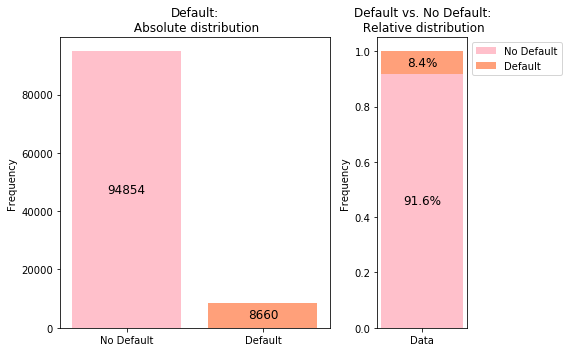

In [63]:
keys, counts = np.unique(data.default, return_counts=True)
counts_norm = counts/counts.sum()

fig = plt.figure(figsize=(8, 5)) #specify figure size
gs = gridspec.GridSpec(1, 2, width_ratios=[3,1]) #specify relative size of left and right plot

#Absolute values
ax0 = plt.subplot(gs[0])
ax0 = plt.bar(['No Default', 'Default'], 
              counts, color=['pink','lightsalmon']) #left bar plot
ax0 = plt.title('Default:\n Absolute distribution') 
ax0 = plt.ylabel('Frequency')
ax0 = plt.text(['No Default'], counts[0]/2, counts[0],  fontsize=12, horizontalalignment='center', verticalalignment='center') 
ax0 = plt.text(['Default'], counts[1]/2, counts[1],  fontsize=12, horizontalalignment='center', verticalalignment='center')

#Normalized values
ax1 = plt.subplot(gs[1])
ax1 = plt.bar(['Data'], [counts_norm[0]], label='No Default', color=['pink'])
ax1 = plt.bar(['Data'], [counts_norm[1]], bottom=counts_norm[0], label='Default', color=['lightsalmon'])
ax1 = plt.legend(bbox_to_anchor=(1, 1))
ax1 = plt.title('Default vs. No Default:\n Relative distribution')
ax1 = plt.ylabel('Frequency')
ax1 = plt.text(['Data'],counts_norm[0]/2, '{}%'.format((counts_norm[0]*100).round(1)), fontsize=12, horizontalalignment='center', verticalalignment='center')
ax1 = plt.text(['Data'],(counts_norm[1]/2)+counts_norm[0], '{}%'.format((counts_norm[1]*100).round(1)), fontsize=12, horizontalalignment='center', verticalalignment='center')

plt.tight_layout()
plt.show()

## Split Data

In [64]:
X_train, y_train = data.loc[:, data.columns != 'default'], data['default'] #define feature matrix X and labels y

In [65]:
#data_test = data_test.drop(['int_rate'], axis=1)
X_test, y_test = data_test.loc[:, data_test.columns != 'default'], data_test['default'] 

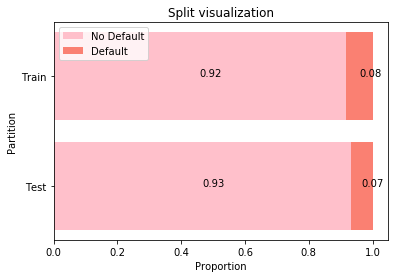

In [66]:
train_dist = y_train.value_counts() / len(y_train) #normalize absolute count values for plotting
test_dist = y_test.value_counts() / len(y_test)
#data_dist = y.value_counts() / len(y)

fig, ax = plt.subplots()

ax.barh(['Test','Train'], [test_dist[0], train_dist[0]], color='pink', label='No Default')
ax.barh(['Test','Train'], [test_dist[1], train_dist[1]], left=[test_dist[0], train_dist[0]], color='salmon', label='Default')
ax.set_title('Split visualization')
ax.legend(loc='upper left')
plt.xlabel('Proportion')
plt.ylabel('Partition')

#plot bar values
for part, a, b in zip(['Test', 'Train'], [test_dist[0], train_dist[0]], [test_dist[1], train_dist[1]]):
    plt.text(a/2, part, str(np.round(a, 2)))
    plt.text(b/2+a, part, str(np.round(b, 2)));

## SMOTE

In [67]:
smote = SMOTE('minority', random_state = 12345)
X_sm, y_sm = smote.fit_sample(X_train, y_train) #ONLY APPLIED TO TRAINING!!!

In [68]:
def plot_2d_space(X, y, label='Classes', title='x', xlabel='x', ylabel='y'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m, s=2
        )
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc='upper right')

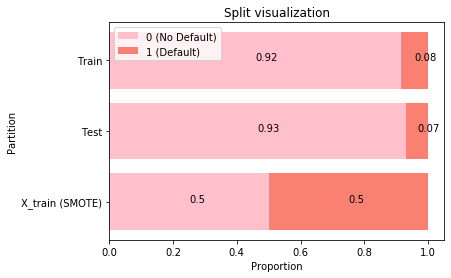

In [69]:
train_dist = y_train.value_counts() / len(y_train) #normalize absolute count values for plotting
test_dist = y_test.value_counts() / len(y_test)
smote_dist = pd.Series(y_sm).value_counts() / len(pd.Series(y_sm))

fig, ax = plt.subplots()

ax.barh(['X_train (SMOTE)','Test','Train'], [smote_dist[0], test_dist[0], train_dist[0]], color='pink', label='0 (No Default)')
ax.barh(['X_train (SMOTE)','Test','Train'], [smote_dist[1], test_dist[1], train_dist[1]], left=[smote_dist[0], test_dist[0], train_dist[0]], color='salmon', label='1 (Default)')
ax.set_title('Split visualization')
ax.legend(loc='upper left')
plt.xlabel('Proportion')
plt.ylabel('Partition')

#plot bar values
for part, a, b in zip(['X_train (SMOTE)', 'Test', 'Train','Data'], [smote_dist[0], test_dist[0], train_dist[0]], [smote_dist[1], test_dist[1], train_dist[1]]):
    plt.text(a/2, part, str(np.round(a, 2)))
    plt.text(b/2+a, part, str(np.round(b, 2)));

## Random Forest (Imbalanced)

In [70]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [71]:
from sklearn.ensemble import RandomForestClassifier

# Make the random forest classifier
rf_imb = RandomForestClassifier(n_estimators = 500, criterion = 'gini', random_state = 100, verbose = 1, n_jobs = -1, 
                                max_depth = 4, max_features = 'auto', bootstrap = True)
#Fit the training data 
rf_imb.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    6.8s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=100, verbose=1,
                       warm_start=False)

In [72]:
#Use classifier to predict labels
y_pred_rf_imb = rf_imb.predict(X_test)
y_pred_proba_rf_imb = rf_imb.predict_proba(X_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    1.0s finished


In [73]:
importances = rf_imb.feature_importances_
indices = np.argsort(importances)[::-1]
feature_order = np.array([X_test.columns.values])
i = np.argsort(importances)[::-1]
feature_order = feature_order[:,i]

In [74]:
# Accuracy score
print ("Accuracy is: ", (accuracy_score(y_test,y_pred_rf_imb)*100).round(2))

Accuracy is:  93.2


### Default Probability Predictive Results (Imbalanced)

In [75]:
# Output
LGD = 0.4
output_rf_imb = pd.DataFrame(y_test)
output_rf_imb.reset_index(drop=True, inplace=True)
output_rf_imb['class_default'] = pd.DataFrame(y_pred_rf_imb)
output_rf_imb['prob_No_default'] = pd.DataFrame(y_pred_proba_rf_imb[:, 0])
output_rf_imb['prob_default'] = pd.DataFrame(y_pred_proba_rf_imb[:, 1])
output_rf_imb['ERL'] = LGD * output_rf_imb['prob_default']
output_rf_imb['int_rate'] = data_test_withint['int_rate']
output_rf_imb['Expected_return'] = data_test_withint['int_rate'] - output_rf_imb['ERL']
output_rf_imb['Relative_expected_return'] = output_rf_imb['Expected_return'] / data_test_withint['int_rate']
output_rf_imb.head(11).style

,default,class_default,prob_No_default,prob_default,ERL,int_rate,Expected_return,Relative_expected_return
0,0,0,0.948062,0.0519385,0.0207754,0.0532,0.0324246,0.609485
1,0,0,0.938329,0.0616709,0.0246684,0.0749,0.0502316,0.670649
2,0,0,0.917769,0.0822314,0.0328925,0.0532,0.0203075,0.381719
3,0,0,0.942955,0.0570452,0.0228181,0.1274,0.104582,0.820894
4,0,0,0.930873,0.0691265,0.0276506,0.1699,0.142249,0.837254
5,0,0,0.937896,0.0621043,0.0248417,0.1144,0.0895583,0.782852
6,0,0,0.935059,0.064941,0.0259764,0.1499,0.123924,0.826708
7,0,0,0.912103,0.0878973,0.0351589,0.1274,0.0922411,0.724027
8,0,0,0.929987,0.0700128,0.0280051,0.1349,0.106895,0.792401
9,0,0,0.930391,0.0696089,0.0278436,0.0699,0.0420564,0.601666


In [76]:
output_rf_imb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96745 entries, 0 to 96744
Data columns (total 8 columns):
default                     96745 non-null int64
class_default               96745 non-null int64
prob_No_default             96745 non-null float64
prob_default                96745 non-null float64
ERL                         96745 non-null float64
int_rate                    96745 non-null float64
Expected_return             96745 non-null float64
Relative_expected_return    96745 non-null float64
dtypes: float64(6), int64(2)
memory usage: 5.9 MB


In [77]:
y_pred_rf_imb[5]
y_pred_proba_rf_imb[5,:]
#y_pred_log_proba

array([0.9378957, 0.0621043])

In [78]:
from sklearn.metrics import classification_report
target_names = ['No Default', 'Default']
print(classification_report(y_test, y_pred_rf_imb, target_names=target_names))

              precision    recall  f1-score   support

  No Default       0.93      1.00      0.96     90170
     Default       0.00      0.00      0.00      6575

    accuracy                           0.93     96745
   macro avg       0.47      0.50      0.48     96745
weighted avg       0.87      0.93      0.90     96745



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Random Forest (Balanced)

In [79]:
# Make the random forest classifier
rf_bal = RandomForestClassifier(n_estimators = 500, criterion = 'gini', random_state = 100, verbose = 1, n_jobs = -1, 
                                max_depth = 4, max_features = 'auto', bootstrap = True)
#Fit the training data 
rf_bal.fit(X_sm, y_sm)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   14.6s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=100, verbose=1,
                       warm_start=False)

In [80]:
#Use classifier to predict labels
y_pred_rf_bal = rf_bal.predict(X_test)
y_pred_proba_rf_bal = rf_bal.predict_proba(X_test)
#y_pred_log_proba_sm = rf_bal.predict_log_proba(X_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    1.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    1.0s finished


In [81]:
importances = rf_bal.feature_importances_
indices = np.argsort(importances)[::-1]
feature_order = np.array([X_test.columns.values])
i = np.argsort(importances)[::-1]
feature_order = feature_order[:,i]

In [82]:
# Accuracy score
print ("Accuracy is: ", (accuracy_score(y_test,y_pred_rf_bal)*100).round(2))

Accuracy is:  89.25


### Default Probability Predictive Results (Balanced)

In [83]:
# Output
LGD = 0.4
output_rf_bal = pd.DataFrame(y_test)
output_rf_bal.reset_index(drop=True, inplace=True)
output_rf_bal['class_default'] = pd.DataFrame(y_pred_rf_bal)
output_rf_bal['prob_No_default'] = pd.DataFrame(y_pred_proba_rf_bal[:, 0])
output_rf_bal['prob_default'] = pd.DataFrame(y_pred_proba_rf_bal[:, 1])
output_rf_bal['ERL'] = LGD * output_rf_bal['prob_default']
output_rf_bal['int_rate'] = data_test_withint['int_rate']
output_rf_bal['Expected_return'] = data_test_withint['int_rate'] - output_rf_bal['ERL']
output_rf_bal['Relative_expected_return'] = output_rf_bal['Expected_return'] / data_test_withint['int_rate']
output_rf_bal.head(11).style

,default,class_default,prob_No_default,prob_default,ERL,int_rate,Expected_return,Relative_expected_return
0,0,0,0.759044,0.240956,0.0963825,0.0532,-0.0431825,-0.811702
1,0,0,0.744737,0.255263,0.102105,0.0749,-0.0272051,-0.363219
2,0,0,0.720574,0.279426,0.11177,0.0532,-0.0585704,-1.10095
3,0,0,0.742568,0.257432,0.102973,0.1274,0.0244271,0.191736
4,0,0,0.7892,0.2108,0.0843202,0.1699,0.0855798,0.503707
5,0,0,0.760929,0.239071,0.0956284,0.1144,0.0187716,0.164088
6,0,0,0.664121,0.335879,0.134352,0.1499,0.0155485,0.103726
7,0,0,0.660098,0.339902,0.135961,0.1274,-0.00856084,-0.0671965
8,0,0,0.72518,0.27482,0.109928,0.1349,0.0249721,0.185116
9,0,0,0.668364,0.331636,0.132654,0.0699,-0.0627545,-0.897775


In [84]:
print(classification_report(y_test, y_pred_rf_bal, target_names=target_names))

              precision    recall  f1-score   support

  No Default       0.93      0.95      0.94     90170
     Default       0.12      0.09      0.10      6575

    accuracy                           0.89     96745
   macro avg       0.53      0.52      0.52     96745
weighted avg       0.88      0.89      0.89     96745



In [85]:
output_rf_bal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96745 entries, 0 to 96744
Data columns (total 8 columns):
default                     96745 non-null int64
class_default               96745 non-null int64
prob_No_default             96745 non-null float64
prob_default                96745 non-null float64
ERL                         96745 non-null float64
int_rate                    96745 non-null float64
Expected_return             96745 non-null float64
Relative_expected_return    96745 non-null float64
dtypes: float64(6), int64(2)
memory usage: 5.9 MB


## Confusion Matrix

In [86]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylim([1.5, -0.5]) #added to fix a bug that causes the matrix to be squished
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

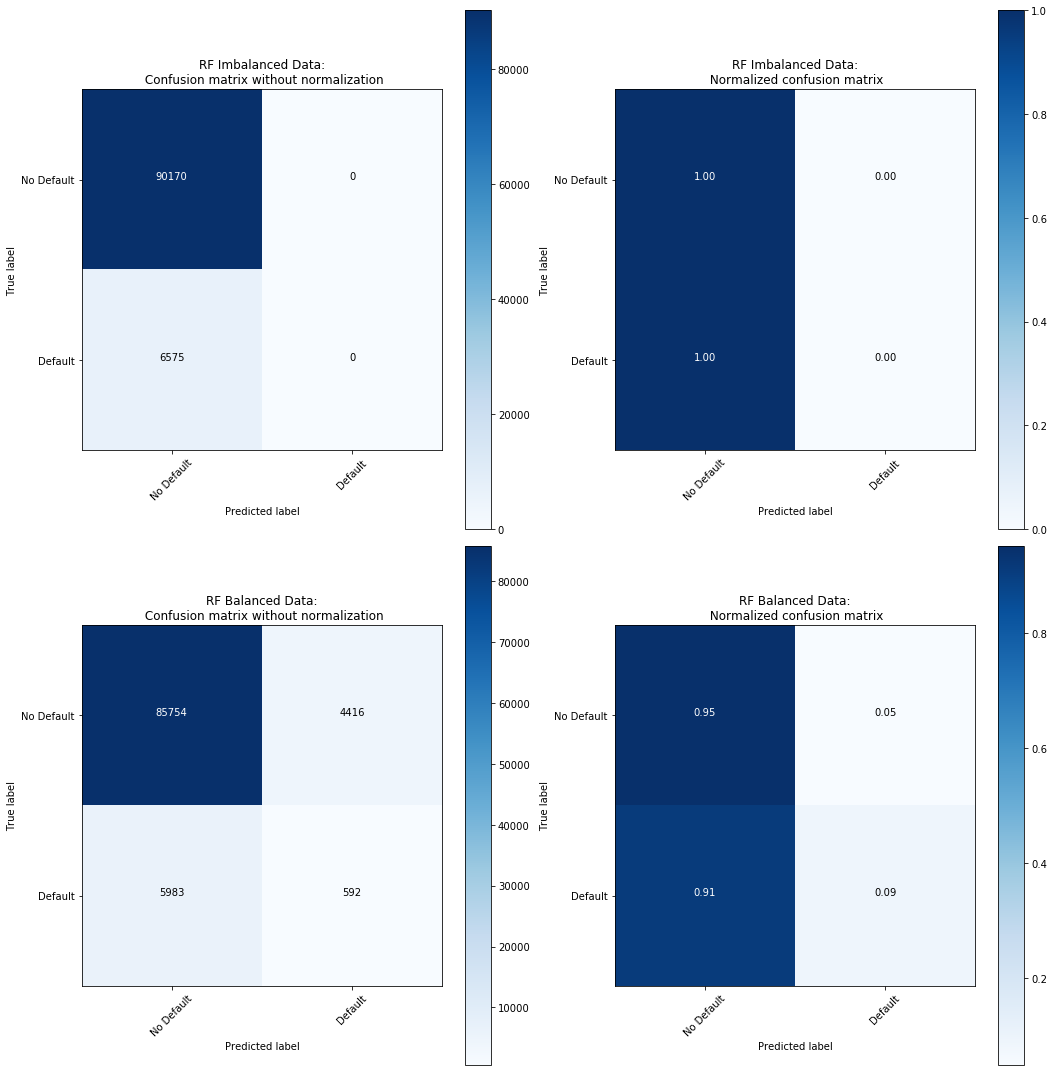

In [87]:
# Compute confusion matrix
class_names = ['No Default', 'Default']
cnf_matrix_rf_imb = confusion_matrix(y_test, y_pred_rf_imb)
cnf_matrix_rf_bal = confusion_matrix(y_test, y_pred_rf_bal)

np.set_printoptions(precision=2)

plt.figure(figsize=(15, 15))

#Plot RF imbalanced confusion matrix
plt.subplot(221) 
plot_confusion_matrix(cnf_matrix_rf_imb, classes=class_names,
                      title='RF Imbalanced Data:\n Confusion matrix without normalization')

#Plot RF imbalanced normalized confusion matrix
plt.subplot(222) 
plot_confusion_matrix(cnf_matrix_rf_imb, classes=class_names, normalize=True,
                      title='RF Imbalanced Data:\n Normalized confusion matrix')

#Plot RF Balanced confusion matrix
plt.subplot(223) 
plot_confusion_matrix(cnf_matrix_rf_bal, classes=class_names,
                      title='RF Balanced Data:\n Confusion matrix without normalization')

#Plot RF Balanced normalized confusion matrix
plt.subplot(224) 
plot_confusion_matrix(cnf_matrix_rf_bal, classes=class_names, normalize=True,
                      title='RF Balanced Data:\n Normalized confusion matrix')

plt.show()

## AUC & ROC

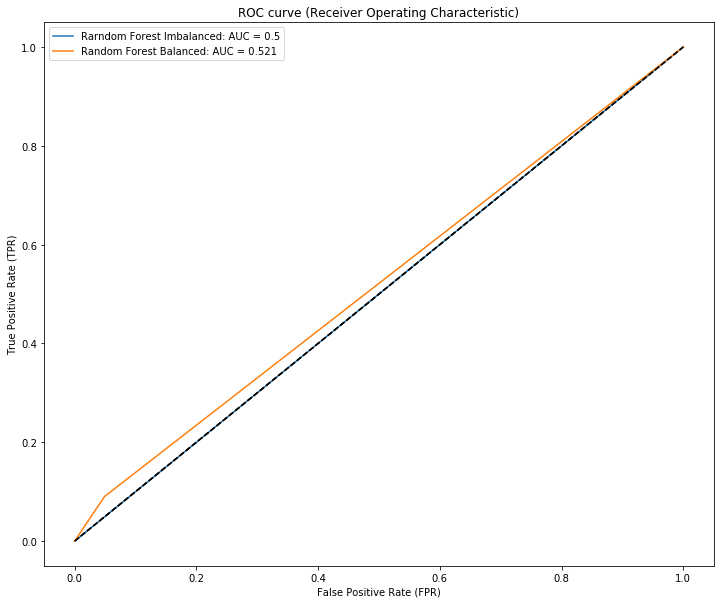

In [88]:
plt.figure(figsize=(12,10))

for test, pred, num, name in zip([y_test, y_test], [y_pred_rf_imb, y_pred_rf_bal], range(1,3), ['Rarndom Forest Imbalanced', 'Random Forest Balanced']):
    fpr, tpr, thresholds = roc_curve(test, pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='{}: AUC = {}'.format(name, round(roc_auc, 3)))
    plt.legend(loc='best')
    plt.plot([0,1],[0,1],color='black', linestyle='--')

plt.title('ROC curve (Receiver Operating Characteristic)')    
plt.ylabel('True Positive Rate (TPR)')
plt.xlabel('False Positive Rate (FPR)')

plt.show()

## Parameter Tuning

Based on the documentation on the random forest in Scikit-Learn, we see that the most important settings are: 
- The number of trees in the forest (n_estimators)
- The max number of levels in each decision tree (max_depth)
- The min number of data points placed in a node before the node is split (min_samples_split)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    1.2s remaining:    

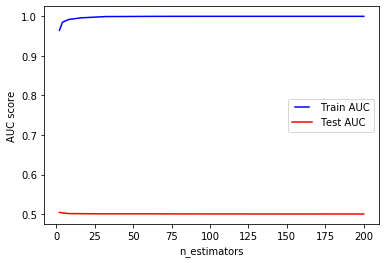

In [89]:
X_train_hyper = X_train.loc[10000:20000, :]
y_train_hyper = y_train.loc[10000:20000]
X_sm_train_hyper, y_sm_train_hyper = smote.fit_sample(X_train_hyper, y_train_hyper) #ONLY APPLIED TO TRAINING!!!

n_estimators = [2, 4, 8, 16, 32, 64, 100, 200]
train_results = []
test_results = []
for estimator in n_estimators:
   rf = RandomForestClassifier(n_estimators=estimator, verbose=1, random_state=100, n_jobs=-1)
   rf.fit(X_sm_train_hyper, y_sm_train_hyper)
   train_pred = rf.predict(X_sm_train_hyper)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_sm_train_hyper, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, 'b', label='Train AUC')
line2, = plt.plot(n_estimators, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()

In [90]:
test_results

[0.504323350359334,
 0.5030021197813509,
 0.501306986254523,
 0.5010321399671344,
 0.5005845907455753,
 0.5005687524747298,
 0.5003794311631894,
 0.5002012000146745]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel

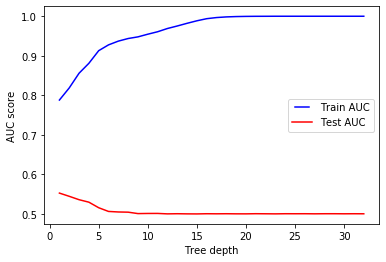

In [91]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   rf = RandomForestClassifier(max_depth=max_depth, verbose=1, random_state=100, n_jobs=-1)
   rf.fit(X_sm_train_hyper, y_sm_train_hyper)
   train_pred = rf.predict(X_sm_train_hyper)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_sm_train_hyper, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_depths, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

In [92]:
test_results

[0.5527159008058712,
 0.544591310625346,
 0.5360169658410329,
 0.5297546164384891,
 0.5157047250419676,
 0.5063386227366896,
 0.5049777543136728,
 0.5044660466014553,
 0.5008705524967414,
 0.501213550576836,
 0.5012856366365012,
 0.5001869388240464,
 0.500537067499455,
 0.5001901098516491,
 0.5000586134091456,
 0.5005204322549168,
 0.5003445751603119,
 0.5005148871734042,
 0.5002756601282495,
 0.5002186237993211,
 0.5005838022054666,
 0.500400025975439,
 0.5001980289870717,
 0.5005354819856537,
 0.5004760716028154,
 0.5005410270671663,
 0.5003144756988384,
 0.5005148871734042,
 0.5005426125809678,
 0.5003738860816767,
 0.5005093420918916,
 0.5003794311631894]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel

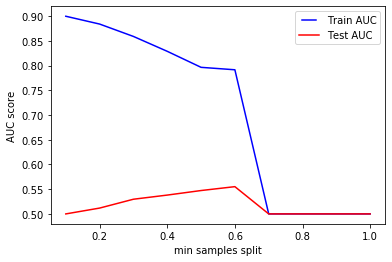

In [93]:
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
   rf = RandomForestClassifier(min_samples_split=min_samples_split, verbose=1, random_state=100, n_jobs=-1)
   rf.fit(X_sm_train_hyper, y_sm_train_hyper)
   train_pred = rf.predict(X_sm_train_hyper)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_sm_train_hyper, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_splits, train_results, 'b', label='Train AUC')
line2, = plt.plot(min_samples_splits, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples split')
plt.show()

In [94]:
test_results

[0.4999770227002565,
 0.5117860475628839,
 0.5296871941508033,
 0.5380738453052979,
 0.5472781577341659,
 0.5551239673603431,
 0.5,
 0.5,
 0.5,
 0.5]

In [95]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [1],
    'min_samples_split': [0.6],
    'n_estimators': [10, 20, 30, 40, 50, 100, 150, 200]
}
# Create a based model
rf = RandomForestClassifier(verbose=1, random_state=100, n_jobs=-1)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, scoring='roc_auc', 
                          cv = 3, n_jobs = -1, verbose = 1)

#'min_samples_leaf': [0.1, 0.2],

In [96]:
grid_search.fit(X_sm, y_sm)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   23.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    2.6s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False, random_state=100,
                                   

In [97]:
grid_search.best_params_

{'max_depth': 1, 'min_samples_split': 0.6, 'n_estimators': 200}

## Random Forest (Balanced + Tuning)

In [98]:
# Make the random forest classifier
rf_bal_hyper = RandomForestClassifier(n_estimators = 200, criterion = 'gini', random_state = 100, verbose = 1, n_jobs = -1, 
                                max_depth = 1, min_samples_split = 0.6)

#Fit the training data 
rf_bal_hyper.fit(X_sm, y_sm)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    2.7s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=1, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=0.6,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=100, verbose=1,
                       warm_start=False)

In [99]:
#Use classifier to predict labels
y_pred_rf_bal_hyper = rf_bal_hyper.predict(X_test)
y_pred_proba_rf_bal_hyper = rf_bal_hyper.predict_proba(X_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


In [100]:
# Accuracy score
print ("Accuracy is: ", (accuracy_score(y_test,y_pred_rf_bal_hyper)*100).round(2))

Accuracy is:  68.77


In [101]:
# Output
LGD = 0.4
output_rf_bal_hyper = pd.DataFrame(y_test)
output_rf_bal_hyper.reset_index(drop=True, inplace=True)
output_rf_bal_hyper['class_default'] = pd.DataFrame(y_pred_rf_bal_hyper)
output_rf_bal_hyper['prob_No_default'] = pd.DataFrame(y_pred_proba_rf_bal_hyper[:, 0])
output_rf_bal_hyper['prob_default'] = pd.DataFrame(y_pred_proba_rf_bal_hyper[:, 1])
output_rf_bal_hyper['ERL'] = LGD * output_rf_bal_hyper['prob_default']
output_rf_bal_hyper['int_rate'] = data_test_withint['int_rate']
output_rf_bal_hyper['Expected_return'] = data_test_withint['int_rate'] - output_rf_bal_hyper['ERL']
output_rf_bal_hyper['Relative_expected_return'] = output_rf_bal_hyper['Expected_return'] / data_test_withint['int_rate']
output_rf_bal_hyper.head(11).style

,default,class_default,prob_No_default,prob_default,ERL,int_rate,Expected_return,Relative_expected_return
0,0,0,0.602988,0.397012,0.158805,0.0532,-0.105605,-1.98505
1,0,0,0.58361,0.41639,0.166556,0.0749,-0.0916561,-1.22371
2,0,0,0.576492,0.423508,0.169403,0.0532,-0.116203,-2.18427
3,0,0,0.601928,0.398072,0.159229,0.1274,-0.0318288,-0.249834
4,0,0,0.608959,0.391041,0.156416,0.1699,0.0134837,0.0793627
5,0,0,0.608062,0.391938,0.156775,0.1144,-0.0423753,-0.370413
6,0,0,0.54836,0.45164,0.180656,0.1499,-0.0307559,-0.205176
7,0,0,0.530549,0.469451,0.18778,0.1274,-0.0603804,-0.473943
8,0,0,0.577615,0.422385,0.168954,0.1349,-0.0340539,-0.252438
9,0,0,0.539003,0.460997,0.184399,0.0699,-0.114499,-1.63804


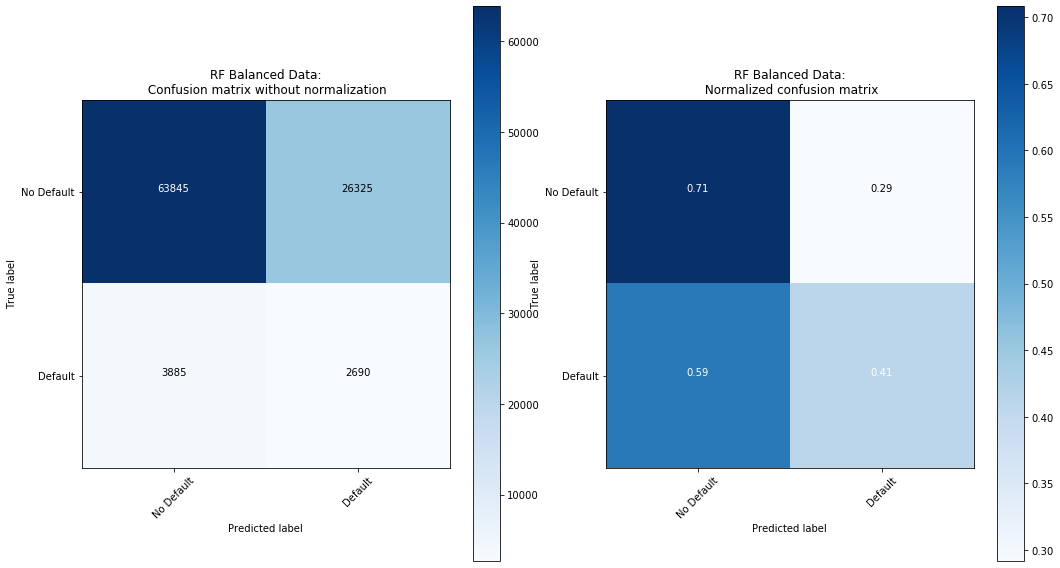

In [102]:
# Compute confusion matrix
class_names = ['No Default', 'Default']
cnf_matrix_rf_bal_hyper = confusion_matrix(y_test, y_pred_rf_bal_hyper)

np.set_printoptions(precision=2)

plt.figure(figsize=(15, 8))

#Plot RF Balanced confusion matrix
plt.subplot(121) 
plot_confusion_matrix(cnf_matrix_rf_bal_hyper, classes=class_names,
                      title='RF Balanced Data:\n Confusion matrix without normalization')

#Plot DT Balanced normalized confusion matrix
plt.subplot(122) 
plot_confusion_matrix(cnf_matrix_rf_bal_hyper, classes=class_names, normalize=True,
                      title='RF Balanced Data:\n Normalized confusion matrix')

plt.show()

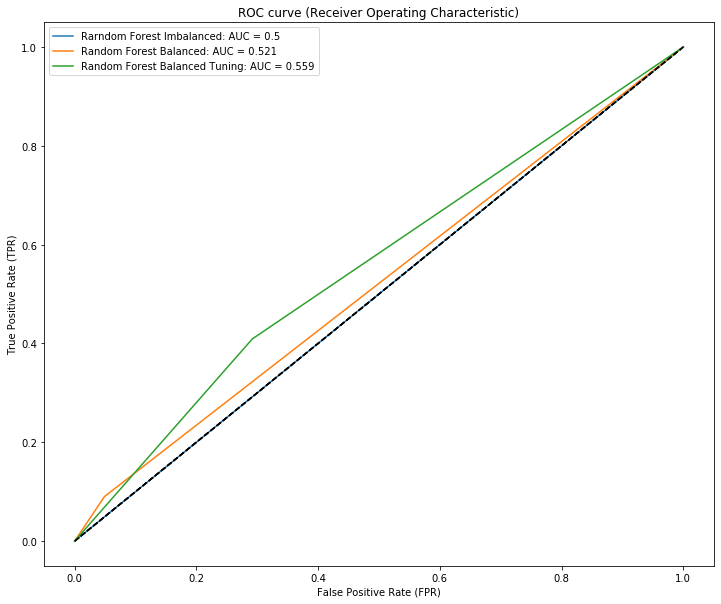

In [103]:
plt.figure(figsize=(12,10))

for test, pred, num, name in zip([y_test, y_test, y_test], [y_pred_rf_imb, y_pred_rf_bal, y_pred_rf_bal_hyper], range(1,4), ['Rarndom Forest Imbalanced', 'Random Forest Balanced', 'Random Forest Balanced Tuning']):
    fpr, tpr, thresholds = roc_curve(test, pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='{}: AUC = {}'.format(name, round(roc_auc, 3)))
    plt.legend(loc='best')
    plt.plot([0,1],[0,1],color='black', linestyle='--')

plt.title('ROC curve (Receiver Operating Characteristic)')    
plt.ylabel('True Positive Rate (TPR)')
plt.xlabel('False Positive Rate (FPR)')

plt.show()

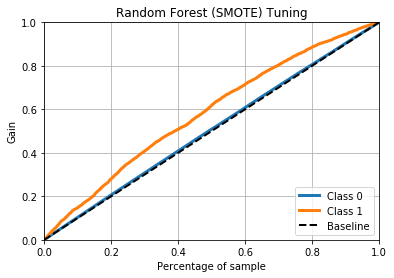

In [104]:
skplt.metrics.plot_cumulative_gain(y_test, y_pred_proba_rf_bal_hyper, title='Random Forest (SMOTE) Tuning')

### Feature Importance

In [105]:
importances = rf_bal_hyper.feature_importances_
indices = np.argsort(importances)[::-1]
feature_order = np.array([X_test.columns.values])
i = np.argsort(importances)[::-1]
feature_order = feature_order[:,i]

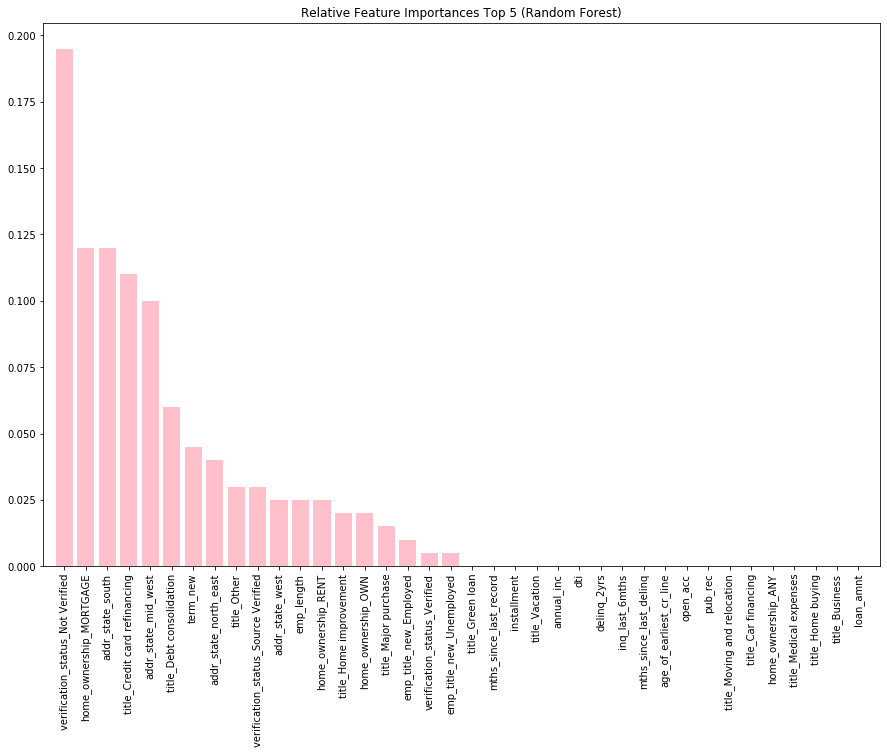

In [106]:
# Plot the feature importances of the forest
plt.figure(figsize=(15, 10))
plt.title("Relative Feature Importances Top 5 (Random Forest)")
plt.bar(range(X_test.shape[1]), importances[indices],
       color="pink",  align="center")
plt.xticks(range(X_test.shape[1]), feature_order[0], rotation=90)
plt.xlim([-1, X_test.shape[1]])
plt.show()

## Logistic Regression (Imbalanced)

In [107]:
lr_imb = LogisticRegression(random_state=123, solver='liblinear') #define Logistic Regression classifier
lr_imb.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [108]:
y_pred_lr_imb = lr_imb.predict(X_test)

In [109]:
print ("Accuracy is: ", (accuracy_score(y_test, y_pred_lr_imb)*100).round(2))

Accuracy is:  93.19


In [110]:
y_predProba_lr_imb = lr_imb.predict_proba(X_test)

In [111]:
# Output
LGD = 0.4
output_lr_imb = pd.DataFrame(y_test)
output_lr_imb.reset_index(drop=True, inplace=True)
output_lr_imb['class_default'] = pd.DataFrame(y_pred_lr_imb)
output_lr_imb['prob_No_default'] = pd.DataFrame(y_predProba_lr_imb[:, 0])
output_lr_imb['prob_default'] = pd.DataFrame(y_predProba_lr_imb[:, 1])
#output_lr_imb['loan_status'] = output_lr_imb['prob_default'].apply(lambda x: 1 if x > 0.5 else 0)
output_lr_imb['ERL'] = LGD * output_lr_imb['prob_default']
output_lr_imb['int_rate'] = data_test_withint['int_rate']
output_lr_imb['Expected_return'] = data_test_withint['int_rate'] - output_lr_imb['ERL']
output_lr_imb['Relative_expected_return'] = output_lr_imb['Expected_return'] / data_test_withint['int_rate']
output_lr_imb.head(11).style

,default,class_default,prob_No_default,prob_default,ERL,int_rate,Expected_return,Relative_expected_return
0,0,0,0.982863,0.0171371,0.00685486,0.0532,0.0463451,0.871149
1,0,0,0.862116,0.137884,0.0551536,0.0749,0.0197464,0.263637
2,0,0,0.933794,0.0662064,0.0264825,0.0532,0.0267175,0.502208
3,0,0,0.950271,0.0497292,0.0198917,0.1274,0.107508,0.843864
4,0,0,0.84953,0.15047,0.0601881,0.1699,0.109712,0.645744
5,0,0,0.921256,0.0787441,0.0314976,0.1144,0.0829024,0.724671
6,0,0,0.9215,0.0785003,0.0314001,0.1499,0.1185,0.790526
7,0,0,0.899645,0.100355,0.0401421,0.1274,0.0872579,0.684913
8,0,0,0.914631,0.085369,0.0341476,0.1349,0.100752,0.746867
9,0,0,0.940044,0.0599563,0.0239825,0.0699,0.0459175,0.656902


In [112]:
output_lr_imb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96745 entries, 0 to 96744
Data columns (total 8 columns):
default                     96745 non-null int64
class_default               96745 non-null int64
prob_No_default             96745 non-null float64
prob_default                96745 non-null float64
ERL                         96745 non-null float64
int_rate                    96745 non-null float64
Expected_return             96745 non-null float64
Relative_expected_return    96745 non-null float64
dtypes: float64(6), int64(2)
memory usage: 5.9 MB


In [113]:
print(classification_report(y_test, y_pred_lr_imb, target_names=target_names))

              precision    recall  f1-score   support

  No Default       0.93      1.00      0.96     90170
     Default       0.00      0.00      0.00      6575

    accuracy                           0.93     96745
   macro avg       0.47      0.50      0.48     96745
weighted avg       0.87      0.93      0.90     96745



## Logistic Regression (Balanced)

In [114]:
lr_bal = LogisticRegression(random_state=123, solver='liblinear') #define Logistic Regression classifier
lr_bal.fit(X_sm, y_sm) #fit LR model to the balanced SMOTE training data

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [115]:
y_pred_lr_bal = lr_bal.predict(X_test)

In [116]:
print ("Accuracy is: ", (accuracy_score(y_test, y_pred_lr_bal)*100).round(2))

Accuracy is:  90.59


In [117]:
y_predProba_lr_bal = lr_bal.predict_proba(X_test)

In [118]:
# Output
LGD = 0.4
output_lr_bal = pd.DataFrame(y_test)
output_lr_bal.reset_index(drop=True, inplace=True)
output_lr_bal['class_default'] = pd.DataFrame(y_pred_lr_bal)
output_lr_bal['prob_No_default'] = pd.DataFrame(y_predProba_lr_bal[:, 0])
output_lr_bal['prob_default'] = pd.DataFrame(y_predProba_lr_bal[:, 1])
output_lr_bal['ERL'] = LGD * output_lr_bal['prob_default']
output_lr_bal['int_rate'] = data_test_withint['int_rate']
output_lr_bal['Expected_return'] = data_test_withint['int_rate'] - output_lr_bal['ERL']
output_lr_bal['Relative_expected_return'] = output_lr_bal['Expected_return'] / data_test_withint['int_rate']
output_lr_bal.head(11).style

,default,class_default,prob_No_default,prob_default,ERL,int_rate,Expected_return,Relative_expected_return
0,0,0,0.935957,0.0640428,0.0256171,0.0532,0.0275829,0.518475
1,0,0,0.967211,0.0327892,0.0131157,0.0749,0.0617843,0.824891
2,0,0,0.958109,0.0418911,0.0167564,0.0532,0.0364436,0.685029
3,0,0,0.919085,0.080915,0.032366,0.1274,0.095034,0.74595
4,0,0,0.967355,0.0326453,0.0130581,0.1699,0.156842,0.923142
5,0,0,0.902106,0.097894,0.0391576,0.1144,0.0752424,0.657713
6,0,0,0.90362,0.0963799,0.0385519,0.1499,0.111348,0.742816
7,0,0,0.942266,0.0577343,0.0230937,0.1274,0.104306,0.818731
8,0,0,0.944833,0.0551671,0.0220668,0.1349,0.112833,0.836421
9,0,0,0.925168,0.0748322,0.0299329,0.0699,0.0399671,0.571776


In [119]:
output_lr_bal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96745 entries, 0 to 96744
Data columns (total 8 columns):
default                     96745 non-null int64
class_default               96745 non-null int64
prob_No_default             96745 non-null float64
prob_default                96745 non-null float64
ERL                         96745 non-null float64
int_rate                    96745 non-null float64
Expected_return             96745 non-null float64
Relative_expected_return    96745 non-null float64
dtypes: float64(6), int64(2)
memory usage: 5.9 MB


In [120]:
print(classification_report(y_test, y_pred_lr_bal, target_names=target_names))

              precision    recall  f1-score   support

  No Default       0.94      0.96      0.95     90170
     Default       0.18      0.11      0.14      6575

    accuracy                           0.91     96745
   macro avg       0.56      0.54      0.54     96745
weighted avg       0.89      0.91      0.89     96745



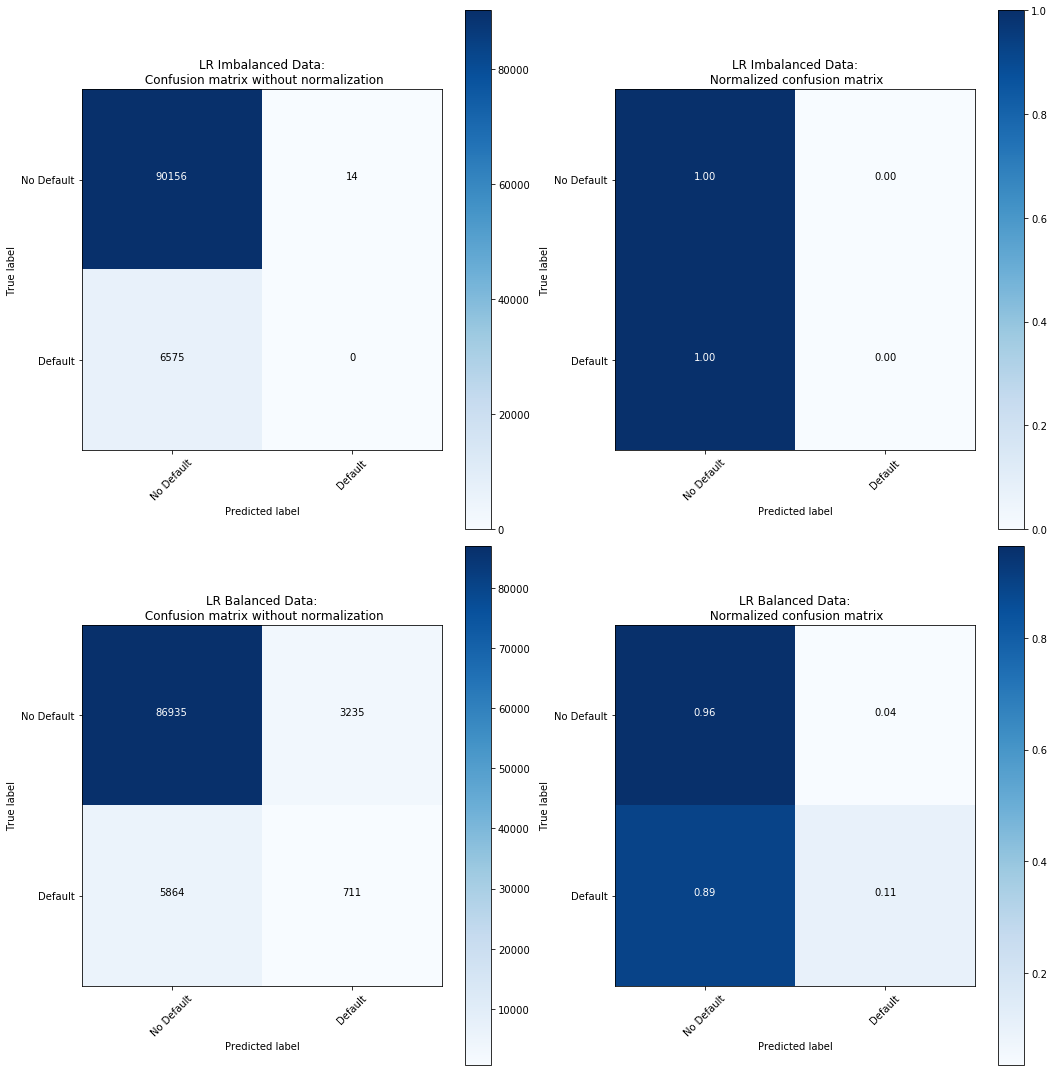

In [121]:
# Compute confusion matrix
class_names = ['No Default', 'Default']
cnf_matrix_lr_imb = confusion_matrix(y_test, y_pred_lr_imb)
cnf_matrix_lr_bal = confusion_matrix(y_test, y_pred_lr_bal)

np.set_printoptions(precision=2)

plt.figure(figsize=(15, 15))

#Plot LR imbalanced confusion matrix
plt.subplot(221) 
plot_confusion_matrix(cnf_matrix_lr_imb, classes=class_names,
                      title='LR Imbalanced Data:\n Confusion matrix without normalization')

#Plot LR imbalanced normalized confusion matrix
plt.subplot(222) 
plot_confusion_matrix(cnf_matrix_lr_imb, classes=class_names, normalize=True,
                      title='LR Imbalanced Data:\n Normalized confusion matrix')

#Plot LR Balanced confusion matrix
plt.subplot(223) 
plot_confusion_matrix(cnf_matrix_lr_bal, classes=class_names,
                      title='LR Balanced Data:\n Confusion matrix without normalization')

#Plot LR Balanced normalized confusion matrix
plt.subplot(224) 
plot_confusion_matrix(cnf_matrix_lr_bal, classes=class_names, normalize=True,
                      title='LR Balanced Data:\n Normalized confusion matrix')

plt.show()

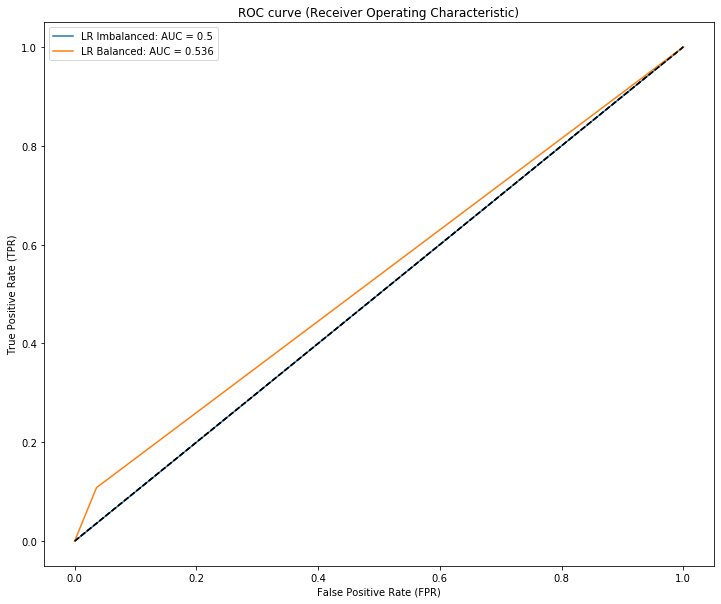

In [122]:
plt.figure(figsize=(12,10))

for test, pred, num, name in zip([y_test, y_test], [y_pred_lr_imb, y_pred_lr_bal], range(1,3), ['LR Imbalanced', 'LR Balanced']):
    fpr, tpr, thresholds = roc_curve(test, pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='{}: AUC = {}'.format(name, round(roc_auc, 3)))
    plt.legend(loc='best')
    plt.plot([0,1],[0,1],color='black', linestyle='--')

plt.title('ROC curve (Receiver Operating Characteristic)')    
plt.ylabel('True Positive Rate (TPR)')
plt.xlabel('False Positive Rate (FPR)')

plt.show()

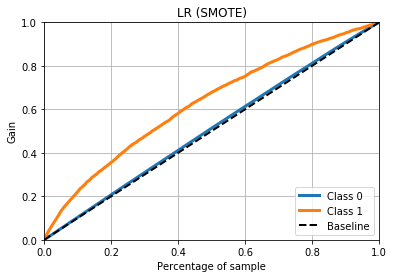

In [123]:
skplt.metrics.plot_cumulative_gain(y_test, y_predProba_lr_bal, title='LR (SMOTE)')

## LR + Lasso (Balanced)

In [124]:
lr_bal_l1 = LogisticRegression(penalty='l1', random_state=123, C=0.0001, solver='liblinear') #define Logistic Regression classifier, lbfgs deault solver
lr_bal_l1.fit(X_sm, y_sm) #fit LR-L1 model to the balanced SMOTE training data

LogisticRegression(C=0.0001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=123, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [125]:
y_pred_lr_l1_bal = lr_bal_l1.predict(X_test)

In [126]:
print ("Accuracy is: ", (accuracy_score(y_test, y_pred_lr_l1_bal)*100).round(2))

Accuracy is:  60.23


In [127]:
y_pred_proba_lr_l1_bal = lr_bal_l1.predict_proba(X_test)

In [128]:
#probabilities
output_lr_l1_bal = pd.DataFrame(y_test)
output_lr_l1_bal.reset_index(drop=True, inplace=True)
output_lr_l1_bal['class_default'] = pd.DataFrame(y_pred_lr_l1_bal)
output_lr_l1_bal['prob_No_default'] = pd.DataFrame(y_pred_proba_lr_l1_bal[:, 0])
output_lr_l1_bal['prob_default'] = pd.DataFrame(y_pred_proba_lr_l1_bal[:, 1])
output_lr_l1_bal['ERL'] = LGD * output_lr_l1_bal['prob_default']
output_lr_l1_bal['int_rate'] = data_test_withint['int_rate']
output_lr_l1_bal['Expected_return'] = data_test_withint['int_rate'] - output_lr_l1_bal['ERL']
output_lr_l1_bal['Relative_expected_return'] = output_lr_l1_bal['Expected_return'] / data_test_withint['int_rate']
output_lr_l1_bal.head(11).style

,default,class_default,prob_No_default,prob_default,ERL,int_rate,Expected_return,Relative_expected_return
0,0,0,0.821783,0.178217,0.0712868,0.0532,-0.0180868,-0.339977
1,0,1,0.498615,0.501385,0.200554,0.0749,-0.125654,-1.67762
2,0,0,0.589729,0.410271,0.164108,0.0532,-0.110908,-2.08474
3,0,0,0.630162,0.369838,0.147935,0.1274,-0.020535,-0.161185
4,0,1,0.478362,0.521638,0.208655,0.1699,-0.0387554,-0.228107
5,0,0,0.573428,0.426572,0.170629,0.1144,-0.0562289,-0.491511
6,0,0,0.511602,0.488398,0.195359,0.1499,-0.0454591,-0.303263
7,0,0,0.533301,0.466699,0.18668,0.1274,-0.0592798,-0.465304
8,0,0,0.511638,0.488362,0.195345,0.1349,-0.0604448,-0.448071
9,0,0,0.638246,0.361754,0.144702,0.0699,-0.0748016,-1.07012


In [129]:
output_lr_l1_bal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96745 entries, 0 to 96744
Data columns (total 8 columns):
default                     96745 non-null int64
class_default               96745 non-null int64
prob_No_default             96745 non-null float64
prob_default                96745 non-null float64
ERL                         96745 non-null float64
int_rate                    96745 non-null float64
Expected_return             96745 non-null float64
Relative_expected_return    96745 non-null float64
dtypes: float64(6), int64(2)
memory usage: 5.9 MB


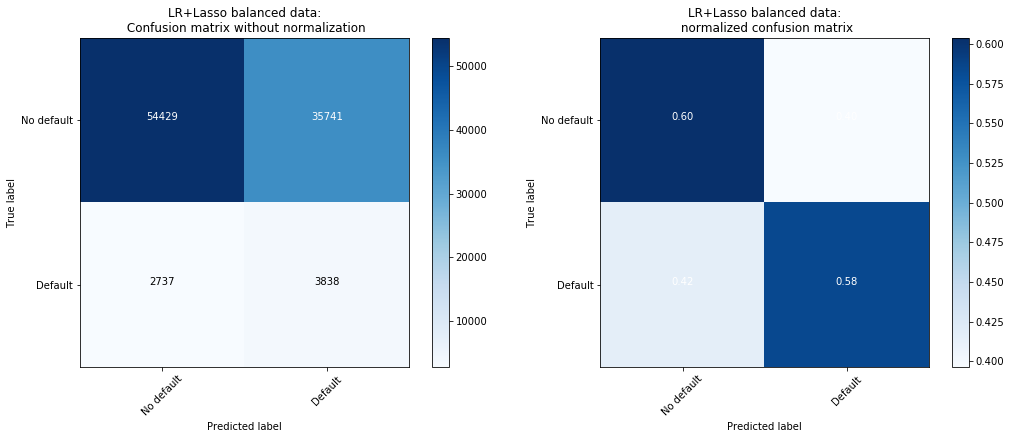

In [130]:
# Compute confusion matrix
class_names = ['No default', 'Default']
cnf_matrix_lr_l1_bal = confusion_matrix(y_test, y_pred_lr_l1_bal)

np.set_printoptions(precision=2)

plt.figure(figsize=(15, 6))

#Plot LR balanced confusion matrix
plt.subplot(121) 
plot_confusion_matrix(cnf_matrix_lr_l1_bal, classes=class_names,
                      title='LR+Lasso balanced data:\n Confusion matrix without normalization')

#Plot LR balanced normalized confusion matrix
plt.subplot(122) 
plot_confusion_matrix(cnf_matrix_lr_l1_bal, classes=class_names, normalize=True,
                      title='LR+Lasso balanced data:\n normalized confusion matrix')

plt.show()

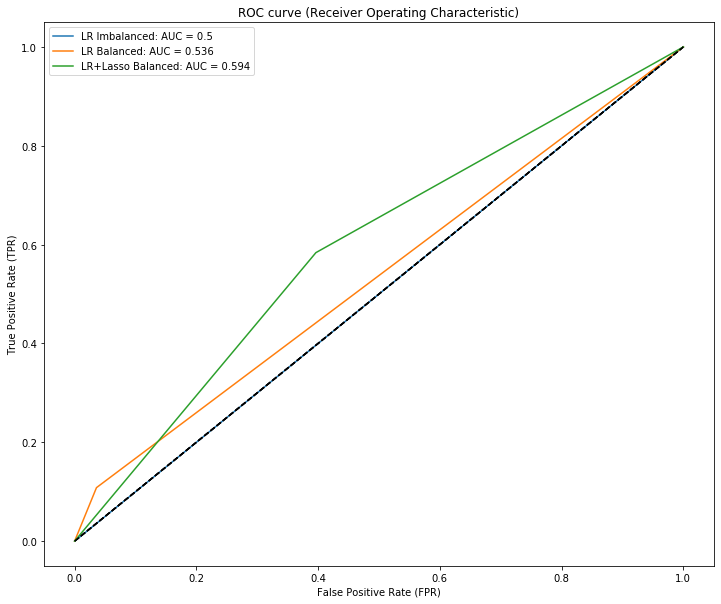

In [131]:
plt.figure(figsize=(12,10))

for test, pred, num, name in zip([y_test, y_test, y_test], [y_pred_lr_imb, y_pred_lr_bal, y_pred_lr_l1_bal], range(1,4), ['LR Imbalanced', 'LR Balanced', 'LR+Lasso Balanced']):
    fpr, tpr, thresholds = roc_curve(test, pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='{}: AUC = {}'.format(name, round(roc_auc, 3)))
    plt.legend(loc='best')
    plt.plot([0,1],[0,1],color='black', linestyle='--')

plt.title('ROC curve (Receiver Operating Characteristic)')    
plt.ylabel('True Positive Rate (TPR)')
plt.xlabel('False Positive Rate (FPR)')

plt.show()

In [132]:
print(classification_report(y_test, y_pred_lr_l1_bal, target_names=target_names))

              precision    recall  f1-score   support

  No Default       0.95      0.60      0.74     90170
     Default       0.10      0.58      0.17      6575

    accuracy                           0.60     96745
   macro avg       0.52      0.59      0.45     96745
weighted avg       0.89      0.60      0.70     96745



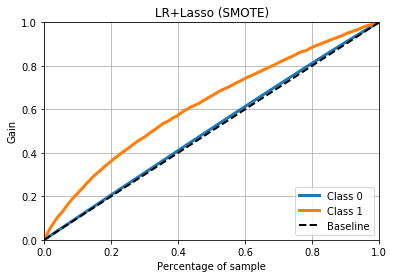

In [133]:
skplt.metrics.plot_cumulative_gain(y_test, y_pred_proba_lr_l1_bal, title='LR+Lasso (SMOTE)')

### Feature Importance

In [134]:
from sklearn.feature_selection import SelectFromModel

smf=SelectFromModel(lr_bal_l1, max_features=5)
smf.fit(X_sm, y_sm)
feature_idx=smf.get_support()
feature_name=X_sm.columns[feature_idx]
feature_name

Index(['emp_length', 'open_acc', 'term_new', 'home_ownership_MORTGAGE',
       'verification_status_Not Verified'],
      dtype='object')

In [135]:
import statsmodels.api as sm
from scipy import stats

params = np.append(lr_bal_l1.coef_, lr_bal_l1.intercept_,)
newX = pd.DataFrame({"Constant":np.ones(len(X_sm))}).join(pd.DataFrame(X_sm))
MSE = (sum((y_test-y_pred_lr_l1_bal)**2))/(len(newX)-len(newX.columns))

var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
sd_b = np.sqrt(var_b)
ts_b = params/ sd_b

p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-1))) for i in ts_b]

sd_b = np.round(sd_b,7)
ts_b = np.round(ts_b,5)
p_values = np.round(p_values,2)
params = np.round(params,10)

myDF3 = pd.DataFrame()
myDF3["Coefficients"],myDF3["Standard Errors"],myDF3["t_values"],myDF3["Probabilites"] = [params,sd_b,ts_b,p_values]
myDF3['column_name'] = pd.concat([pd.DataFrame(X_train.columns)])
myDF3['column_name'] = myDF3['column_name'].fillna('intercep')
myDF3['abs_t_values']=np.abs(myDF3['t_values'])
myDF3 = myDF3.sort_values(by=['abs_t_values'], ascending=False)
myDF3

,Coefficients,Standard Errors,t_values,Probabilites,column_name,abs_t_values
4,0.004442,0.000000e+00,250581.33535,0.00,dti,250581.33535
9,-0.016318,4.000000e-07,-37700.46344,0.00,open_acc,37700.46344
1,0.004800,7.000000e-07,6955.03995,0.00,installment,6955.03995
2,-0.009775,2.050000e-05,-477.81898,0.00,emp_length,477.81898
8,-0.000033,2.000000e-07,-149.25943,0.00,mths_since_last_record,149.25943
19,-0.052745,3.210800e-03,-16.42768,0.00,verification_status_Not Verified,16.42768
12,-0.001756,1.757000e-04,-9.99501,0.00,age_of_earliest_cr_line,9.99501
11,0.019960,2.773500e-03,7.19646,0.00,term_new,7.19646
16,-0.220583,4.428390e-02,-4.98110,0.00,home_ownership_MORTGAGE,4.98110
7,-0.000026,1.340000e-03,-0.01941,0.98,mths_since_last_delinq,0.01941


In [136]:
coefficients = pd.concat([pd.DataFrame(X_train.columns), pd.DataFrame(np.transpose(lr_bal_l1.coef_))], axis = 1)
coefficients.columns = ['name', 'coefficients']
coefficients['abs_coefficients']=np.abs(coefficients['coefficients'])
coefficients = coefficients.sort_values(by=['abs_coefficients'], ascending=False)
coefficients.reindex(coefficients.coefficients.abs().sort_values(ascending=False).index)
coefficients.reindex(coefficients.coefficients.abs().sort_values(ascending=True).index)
coefficients

,name,coefficients,abs_coefficients
16,home_ownership_MORTGAGE,-0.220583,0.220583
19,verification_status_Not Verified,-0.052745,0.052745
11,term_new,0.019960,0.019960
9,open_acc,-0.016318,0.016318
2,emp_length,-0.009775,0.009775
1,installment,0.004800,0.004800
4,dti,0.004442,0.004442
12,age_of_earliest_cr_line,-0.001756,0.001756
0,loan_amnt,-0.000129,0.000129
8,mths_since_last_record,-0.000033,0.000033


In [137]:
output_lr_l1_bal.to_csv("output_lr_l1_bal.csv", index=False, encoding='utf8')

In [138]:
output_rf_bal_hyper.to_csv('output_rf_bal_data.csv', index=False, encoding='utf8')

## XGBoost

In [139]:
from sklearn.metrics import mean_squared_error
from numpy import loadtxt
!pip install xgboost
from xgboost import XGBClassifier

     |████████████████████████████████| 109.8MB 44.9MB/s eta 0:00:01.0MB/s eta 0:00:22     |██████████                      | 34.2MB 40.7MB/s eta 0:00:02     |████████████████████▋           | 70.5MB 45.9MB/s eta 0:00:01


In [140]:
#XGB_imb = XGBClassifier()
XGB_imb = XGBClassifier(max_depth=4, n_estimators=100, learning_rate=0.05, objective= 'binary:logistic', random_state=123)
XGB_imb.fit(X_train, y_train, early_stopping_rounds=35,  eval_metric="logloss", eval_set=[(X_test, y_test)])

[0]	validation_0-logloss:0.65777
Will train until validation_0-logloss hasn't improved in 35 rounds.
[1]	validation_0-logloss:0.62584
[2]	validation_0-logloss:0.59675
[3]	validation_0-logloss:0.57018
[4]	validation_0-logloss:0.54590
[5]	validation_0-logloss:0.52367
[6]	validation_0-logloss:0.50328
[7]	validation_0-logloss:0.48447
[8]	validation_0-logloss:0.46719
[9]	validation_0-logloss:0.45124
[10]	validation_0-logloss:0.43650
[11]	validation_0-logloss:0.42291
[12]	validation_0-logloss:0.41031
[13]	validation_0-logloss:0.39865
[14]	validation_0-logloss:0.38782
[15]	validation_0-logloss:0.37779
[16]	validation_0-logloss:0.36852
[17]	validation_0-logloss:0.35985
[18]	validation_0-logloss:0.35183
[19]	validation_0-logloss:0.34436
[20]	validation_0-logloss:0.33744
[21]	validation_0-logloss:0.33100
[22]	validation_0-logloss:0.32499
[23]	validation_0-logloss:0.31939
[24]	validation_0-logloss:0.31419
[25]	validation_0-logloss:0.30934
[26]	validation_0-logloss:0.30484
[27]	validation_0-loglos

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.05, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=123, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [141]:
y_pred_XGB_imb = XGB_imb.predict(X_test) 
y_pred_proba_XGB_imb = XGB_imb.predict_proba(X_test, ntree_limit=XGB_imb.best_ntree_limit)[:,1]

In [142]:
print ("Accuracy is: ", (accuracy_score(y_test, y_pred_XGB_imb)*100).round(2))

Accuracy is:  93.2


In [143]:
#XGB_bal = XGBClassifier()

XGB_bal = XGBClassifier(objective ='binary:logistic', learning_rate = 0.0001, max_depth = 4, n_estimators = 100, random_state=123)
XGB_bal.fit(X_sm, y_sm, early_stopping_rounds=35, eval_metric="logloss", eval_set=[(X_test, y_test)])

[0]	validation_0-logloss:0.69321
Will train until validation_0-logloss hasn't improved in 35 rounds.
[1]	validation_0-logloss:0.69320
[2]	validation_0-logloss:0.69319
[3]	validation_0-logloss:0.69300
[4]	validation_0-logloss:0.69295
[5]	validation_0-logloss:0.69280
[6]	validation_0-logloss:0.69275
[7]	validation_0-logloss:0.69271
[8]	validation_0-logloss:0.69271
[9]	validation_0-logloss:0.69269
[10]	validation_0-logloss:0.69265
[11]	validation_0-logloss:0.69262
[12]	validation_0-logloss:0.69258
[13]	validation_0-logloss:0.69257
[14]	validation_0-logloss:0.69249
[15]	validation_0-logloss:0.69242
[16]	validation_0-logloss:0.69240
[17]	validation_0-logloss:0.69238
[18]	validation_0-logloss:0.69226
[19]	validation_0-logloss:0.69222
[20]	validation_0-logloss:0.69223
[21]	validation_0-logloss:0.69220
[22]	validation_0-logloss:0.69217
[23]	validation_0-logloss:0.69215
[24]	validation_0-logloss:0.69199
[25]	validation_0-logloss:0.69196
[26]	validation_0-logloss:0.69193
[27]	validation_0-loglos

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.0001, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=123, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [144]:
y_pred_XGB_bal = XGB_bal.predict(X_test)
y_pred_proba_XGB_bal = XGB_bal.predict_proba(X_test, ntree_limit=XGB_bal.best_ntree_limit)

In [145]:
y_pred_proba_XGB_bal

array([[0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       ...,
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5]], dtype=float32)

In [146]:
print ("Accuracy is: ", (accuracy_score(y_test, y_pred_XGB_bal)*100).round(2))

Accuracy is:  89.24


In [147]:
# Output
LGD = 0.4
output_XGB_bal = pd.DataFrame(y_test)
output_XGB_bal.reset_index(drop=True, inplace=True)
output_XGB_bal['class_default'] = pd.DataFrame(y_pred_XGB_bal)
output_XGB_bal['prob_No_default'] = pd.DataFrame(y_pred_proba_XGB_bal[:, 0])
output_XGB_bal['prob_default'] = pd.DataFrame(y_pred_proba_XGB_bal[:, 1])
output_XGB_bal['ERL'] = LGD * output_XGB_bal['prob_default']
output_XGB_bal['int_rate'] = data_test_withint['int_rate']
output_XGB_bal['Expected_return'] = data_test_withint['int_rate'] - output_XGB_bal['ERL']
output_XGB_bal['Relative_expected_return'] = output_XGB_bal['Expected_return'] / data_test_withint['int_rate']
output_XGB_bal.head(11).style

,default,class_default,prob_No_default,prob_default,ERL,int_rate,Expected_return,Relative_expected_return
0,0,0,0.50454,0.49546,0.198184,0.0532,-0.144984,-2.72527
1,0,0,0.50454,0.49546,0.198184,0.0749,-0.123284,-1.64598
2,0,0,0.504395,0.495605,0.198242,0.0532,-0.145042,-2.72636
3,0,0,0.504043,0.495957,0.198383,0.1274,-0.070983,-0.557166
4,0,0,0.504104,0.495896,0.198358,0.1699,-0.0284583,-0.1675
5,0,0,0.504104,0.495896,0.198358,0.1144,-0.0839583,-0.733901
6,0,0,0.503401,0.496599,0.19864,0.1499,-0.0487397,-0.325148
7,0,0,0.502521,0.497479,0.198992,0.1274,-0.0715917,-0.561944
8,0,0,0.504395,0.495605,0.198242,0.1349,-0.0633422,-0.469549
9,0,0,0.503455,0.496545,0.198618,0.0699,-0.128718,-1.84146


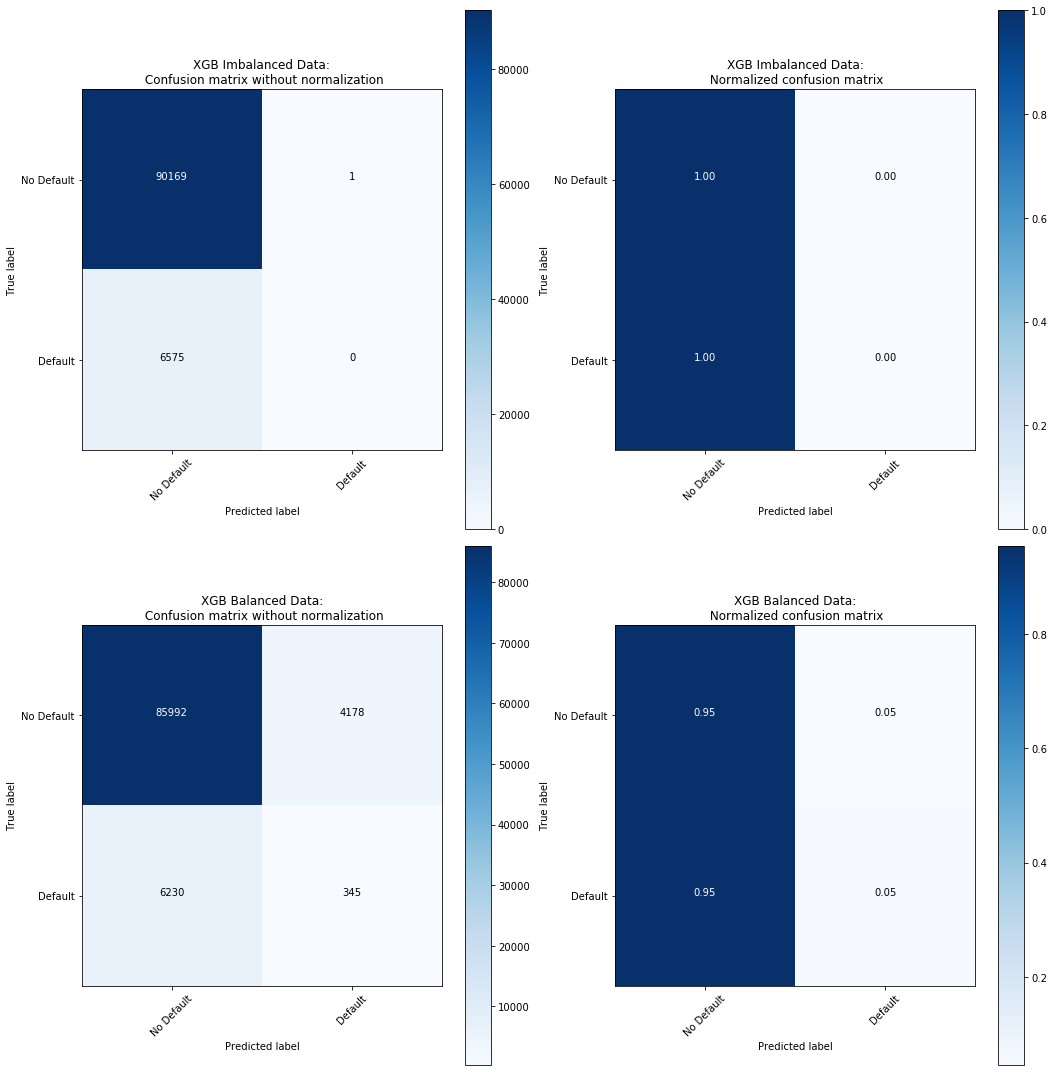

In [148]:
# Compute confusion matrix
class_names = ['No Default', 'Default']
cnf_matrix_XGB_imb = confusion_matrix(y_test, y_pred_XGB_imb)
cnf_matrix_XGB_bal = confusion_matrix(y_test, y_pred_XGB_bal)

np.set_printoptions(precision=2)

plt.figure(figsize=(15, 15))

#Plot XGB imbalanced confusion matrix
plt.subplot(221) 
plot_confusion_matrix(cnf_matrix_XGB_imb, classes=class_names,
                      title='XGB Imbalanced Data:\n Confusion matrix without normalization')

#Plot XGB imbalanced normalized confusion matrix
plt.subplot(222) 
plot_confusion_matrix(cnf_matrix_XGB_imb, classes=class_names, normalize=True,
                      title='XGB Imbalanced Data:\n Normalized confusion matrix')

#Plot XGB Balanced confusion matrix
plt.subplot(223) 
plot_confusion_matrix(cnf_matrix_XGB_bal, classes=class_names,
                      title='XGB Balanced Data:\n Confusion matrix without normalization')

#Plot XGB Balanced normalized confusion matrix
plt.subplot(224) 
plot_confusion_matrix(cnf_matrix_XGB_bal, classes=class_names, normalize=True,
                      title='XGB Balanced Data:\n Normalized confusion matrix')

plt.show()

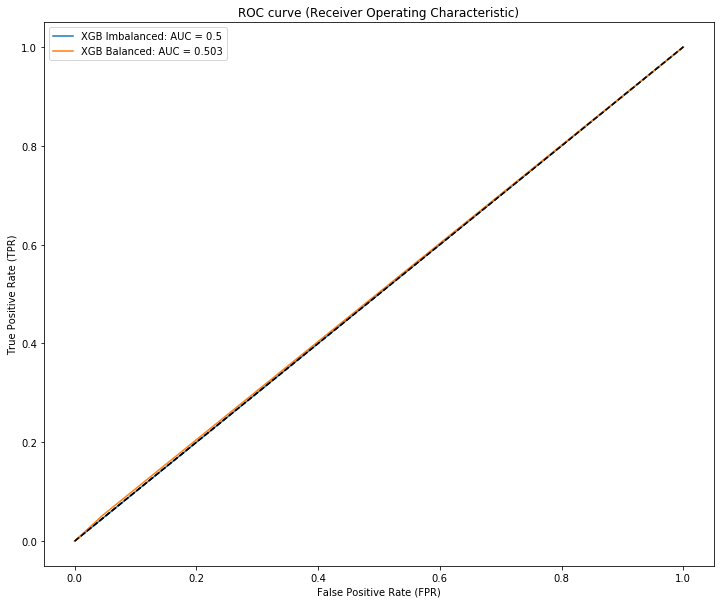

In [149]:
plt.figure(figsize=(12,10))

for test, pred, num, name in zip([y_test, y_test], [y_pred_XGB_imb, y_pred_XGB_bal], range(1,4), ['XGB Imbalanced', 'XGB Balanced']):
    fpr, tpr, thresholds = roc_curve(test, pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='{}: AUC = {}'.format(name, round(roc_auc, 3)))
    plt.legend(loc='best')
    plt.plot([0,1],[0,1],color='black', linestyle='--')

plt.title('ROC curve (Receiver Operating Characteristic)')    
plt.ylabel('True Positive Rate (TPR)')
plt.xlabel('False Positive Rate (FPR)')

plt.show()

In [150]:
print(classification_report(y_test, y_pred_XGB_bal, target_names=target_names))

              precision    recall  f1-score   support

  No Default       0.93      0.95      0.94     90170
     Default       0.08      0.05      0.06      6575

    accuracy                           0.89     96745
   macro avg       0.50      0.50      0.50     96745
weighted avg       0.87      0.89      0.88     96745



## XGBoost (Balanced + Tuning)

In [151]:
XGB_hyper = XGBClassifier(objective= 'binary:logistic', max_depth=1, n_estimators=100, learning_rate=0.01, random_state=123)
XGB_hyper.fit(X_sm, y_sm)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.01, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=123, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [152]:
y_pred_XGB_hyper = XGB_hyper.predict(X_test)
y_pred_proba_XGB_hyper = XGB_hyper.predict_proba(X_test)

In [153]:
print ("Accuracy is: ", (accuracy_score(y_test, y_pred_XGB_hyper)*100).round(2))

Accuracy is:  62.41


In [154]:
# Output
LGD = 0.4
output_XGB_hyper = pd.DataFrame(y_test)
output_XGB_hyper.reset_index(drop=True, inplace=True)
output_XGB_hyper['class_default'] = pd.DataFrame(y_pred_XGB_hyper)
output_XGB_hyper['prob_No_default'] = pd.DataFrame(y_pred_proba_XGB_hyper[:, 0])
output_XGB_hyper['prob_default'] = pd.DataFrame(y_pred_proba_XGB_hyper[:, 1])
output_XGB_hyper['ERL'] = LGD * output_XGB_hyper['prob_default']
output_XGB_hyper['int_rate'] = data_test_withint['int_rate']
output_XGB_hyper['Expected_return'] = data_test_withint['int_rate'] - output_XGB_hyper['ERL']
output_XGB_hyper['Relative_expected_return'] = output_XGB_hyper['Expected_return'] / data_test_withint['int_rate']
output_XGB_hyper.head(11).style

,default,class_default,prob_No_default,prob_default,ERL,int_rate,Expected_return,Relative_expected_return
0,0,0,0.647979,0.352021,0.140808,0.0532,-0.0876083,-1.64677
1,0,0,0.643443,0.356557,0.142623,0.0749,-0.0677229,-0.904178
2,0,0,0.601733,0.398267,0.159307,0.0532,-0.106107,-1.99449
3,0,0,0.643443,0.356557,0.142623,0.1274,-0.0152229,-0.119489
4,0,0,0.66528,0.33472,0.133888,0.1699,0.0360121,0.211961
5,0,0,0.643443,0.356557,0.142623,0.1144,-0.0282229,-0.246704
6,0,0,0.578377,0.421623,0.168649,0.1499,-0.0187491,-0.125078
7,0,0,0.521041,0.478959,0.191583,0.1274,-0.0641835,-0.503795
8,0,0,0.601733,0.398267,0.159307,0.1349,-0.0244067,-0.180925
9,0,0,0.547374,0.452626,0.18105,0.0699,-0.11115,-1.59013


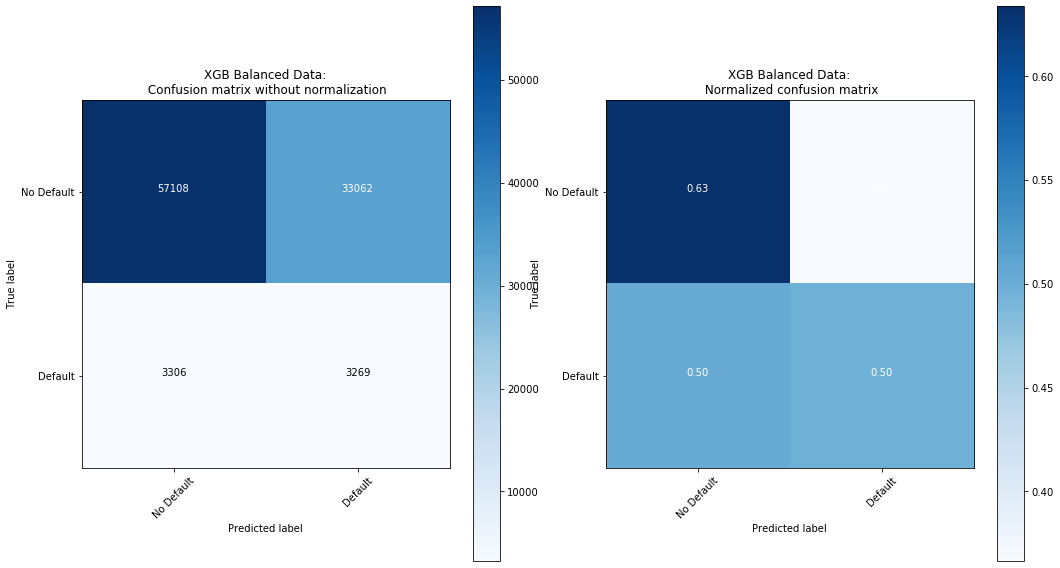

In [155]:
# Compute confusion matrix
class_names = ['No Default', 'Default']
cnf_matrix_XGB_hyper = confusion_matrix(y_test, y_pred_XGB_hyper)

np.set_printoptions(precision=2)

plt.figure(figsize=(15, 8))

#Plot XGB Balanced confusion matrix
plt.subplot(121) 
plot_confusion_matrix(cnf_matrix_XGB_hyper, classes=class_names,
                      title='XGB Balanced Data:\n Confusion matrix without normalization')

#Plot XGB Balanced normalized confusion matrix
plt.subplot(122) 
plot_confusion_matrix(cnf_matrix_XGB_hyper, classes=class_names, normalize=True,
                      title='XGB Balanced Data:\n Normalized confusion matrix')

plt.show()

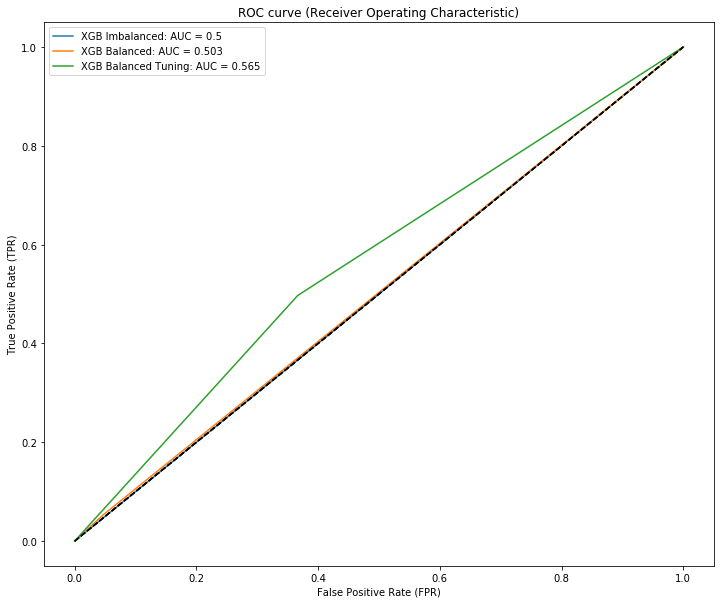

In [156]:
plt.figure(figsize=(12,10))

for test, pred, num, name in zip([y_test, y_test, y_test], [y_pred_XGB_imb, y_pred_XGB_bal, y_pred_XGB_hyper], range(1,4), ['XGB Imbalanced', 'XGB Balanced', 'XGB Balanced Tuning']):
    fpr, tpr, thresholds = roc_curve(test, pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='{}: AUC = {}'.format(name, round(roc_auc, 3)))
    plt.legend(loc='best')
    plt.plot([0,1],[0,1],color='black', linestyle='--')

plt.title('ROC curve (Receiver Operating Characteristic)')    
plt.ylabel('True Positive Rate (TPR)')
plt.xlabel('False Positive Rate (FPR)')

plt.show()

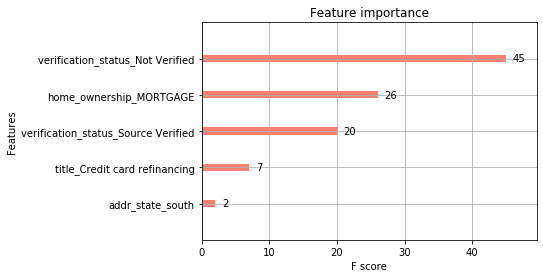

In [157]:
from xgboost import plot_importance
plot_importance(XGB_hyper, color="salmon")
plt.rcParams['figure.figsize'] = [8, 4]
plt.show()

In [158]:
output_XGB_hyper.to_csv('output_XGB_bal_data.csv', index=False, encoding='utf8')

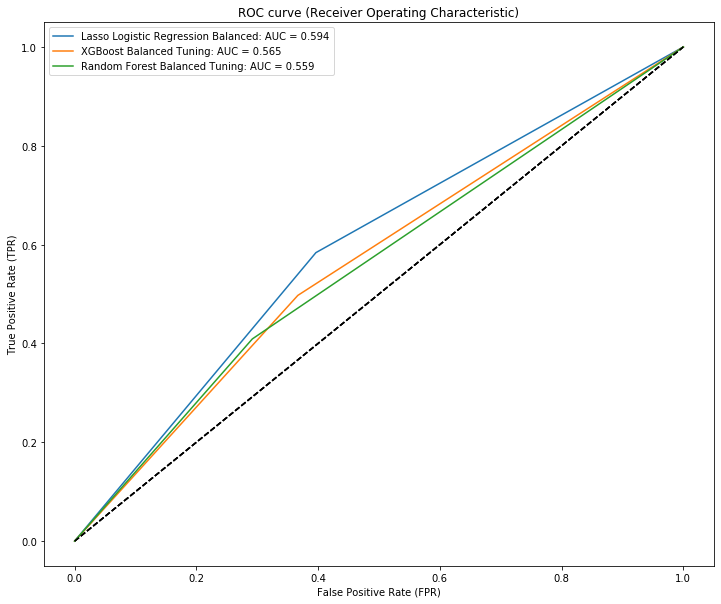

In [159]:
plt.figure(figsize=(12,10))

for test, pred, num, name in zip([y_test, y_test, y_test], [y_pred_lr_l1_bal,y_pred_XGB_hyper,y_pred_rf_bal_hyper], range(1,4), ['Lasso Logistic Regression Balanced', 'XGBoost Balanced Tuning', 'Random Forest Balanced Tuning']):
    fpr, tpr, thresholds = roc_curve(test, pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='{}: AUC = {}'.format(name, round(roc_auc, 3)))
    plt.legend(loc='best')
    plt.plot([0,1],[0,1],color='black', linestyle='--')

plt.title('ROC curve (Receiver Operating Characteristic)')    
plt.ylabel('True Positive Rate (TPR)')
plt.xlabel('False Positive Rate (FPR)')

plt.show()